In [32]:
import pandas as pd
import numpy as np
import torch
from scipy import stats
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import TGNMemory, TransformerConv
from torch_geometric.utils import negative_sampling
from torch_geometric_temporal import recurrent
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal, DynamicHeteroGraphTemporalSignal
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from scipy import stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric_temporal.nn import HeteroGCLSTM
from torch_geometric.nn.norm import GraphNorm
from torch_geometric.nn import GATConv, HeteroConv
from probabilistic_util_fuctions import generate_rfm_data2, generate_rfm_data


#df = pd.read_excel('Online Retail.xlsx')
df = pd.read_csv('online_retail_II.csv')
df.rename(columns = {'Customer ID':'CustomerID', 
                     'Price': 'UnitPrice', 
                     'Invoice': "InvoiceNo"}, inplace = True)


df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [33]:
def aggretate_df(df):
    '''Generte aggregated weekly dataframe with CustomerID, StockCode, InvoiceNo, UnitPrice, Quantity'''
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    first_date = df['InvoiceDate'].min()
    last_date = df['InvoiceDate'].max()
    df['week'] = df['InvoiceDate'].dt.to_period('M')

    aggregated_daframe = pd.DataFrame(columns=['CustomerID', 'StockCode', 'InvoiceNo', 'UnitPrice', 'Quantity', 'Country', 'Description', 'InvoiceDate'])

    for week in df.week.unique():
        _ = week.start_time
        end_date = week.end_time
        week_df = df[df.week == week].copy()
        week_df_aggregated = week_df.groupby(['CustomerID', 'StockCode']).agg({
            'InvoiceNo': 'count',
            'UnitPrice': 'mean', 
            'Quantity': 'sum', 
            'Country': 'first',
            'Description': 'first'}).reset_index()
        week_df_aggregated['InvoiceDate'] = end_date.strftime('%Y-%m-%d')
        # drop rows with quantity <= 0
        week_df_aggregated = week_df_aggregated[week_df_aggregated['Quantity'] > 0]

        #append the aggregated week dataframe to the main dataframe
        aggregated_daframe = pd.concat([aggregated_daframe, week_df_aggregated], ignore_index=True)
    aggregated_daframe['Quantity'] = aggregated_daframe['Quantity'].astype(int)
    return  aggregated_daframe 


In [34]:
test_df = aggretate_df(df)
test_df.shape


(718088, 8)

In [35]:
test_df

,CustomerID,StockCode,InvoiceNo,UnitPrice,Quantity,Country,Description,InvoiceDate
0,12346.0,TEST001,4,4.50,25,United Kingdom,This is a test product.,2009-12-31
1,12346.0,TEST002,1,1.00,1,United Kingdom,This is a test product.,2009-12-31
2,12358.0,15056BL,1,4.95,60,Austria,EDWARDIAN PARASOL BLACK,2009-12-31
3,12358.0,15056N,1,4.95,60,Austria,EDWARDIAN PARASOL NATURAL,2009-12-31
4,12358.0,15056P,1,5.95,30,Austria,EDWARDIAN PARASOL PINK,2009-12-31
...,...,...,...,...,...,...,...,...
718083,18283.0,23582,1,2.08,3,United Kingdom,VINTAGE DOILY JUMBO BAG RED,2011-12-31
718084,18283.0,23583,1,1.65,3,United Kingdom,LUNCH BAG PAISLEY PARK,2011-12-31
718085,18283.0,23681,1,1.65,3,United Kingdom,LUNCH BAG RED VINTAGE DOILY,2011-12-31
718086,18283.0,85099F,1,2.08,3,United Kingdom,JUMBO BAG STRAWBERRY,2011-12-31


In [36]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 718088 entries, 0 to 718087
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   CustomerID   718088 non-null  float64
 1   StockCode    718088 non-null  object 
 2   InvoiceNo    718088 non-null  object 
 3   UnitPrice    718088 non-null  float64
 4   Quantity     718088 non-null  int64  
 5   Country      718088 non-null  object 
 6   Description  718088 non-null  object 
 7   InvoiceDate  718088 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 43.8+ MB


In [5]:
def data_preprocessing(df):

    df = df[df['CustomerID'].notna()].reset_index(drop=True)
    df = df[df.Quantity > 0]
    df = df[df.UnitPrice > 0]
    non_product_codes = ['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'AMAZONFEE', 'DCGSSBOY', 
                         'DCGSSGIRL', 'DOT', 'PADS', 'TEST001','TEST002', 'ADJUST', 'ADJUST2','SP1002']

    df = df[~df['StockCode'].isin(non_product_codes)]

    #time features engeneering
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['month'] = df['InvoiceDate'].dt.month

    df['Year_month'] = df['InvoiceDate'].dt.to_period('M')
    df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
    df['hour_minute'] = df['InvoiceDate'].dt.time

    df['day_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
    df['day_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

    df = pd.get_dummies(df, columns = ['month'], prefix = 'month', drop_first=True)
    #transfomr the boolean columns to int
    df[['month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']] = df[[ 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].astype(int)
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    df['Amount'] = df['Quantity'] * df['UnitPrice']
    df = df[(np.abs(stats.zscore(df['TotalPrice'])) < 3)]
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]
    
    # create first order of the customer column
    df['FirstOrder'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')


    #ebedding for the country and description columns
    country_encoder = LabelEncoder()
    df['CountryID'] = country_encoder.fit_transform(df['Country'])
    desc_encoder = LabelEncoder()
    df['DescriptionID'] = desc_encoder.fit_transform(df['Description'])
    #define embedding layers to be used in the model
    num_countries = df.CountryID.nunique()
    num_description = df.DescriptionID.nunique()
    country_embedding = nn.Embedding( num_embeddings=num_countries, embedding_dim = 4)
    description_embedding = nn.Embedding(num_embeddings=num_description, embedding_dim = 16)
    df = df[df.Year_month != '2011-12']

    return df, country_embedding, description_embedding
def data_preprocessing_alternative(df):

    df = df[df['CustomerID'].notna()].reset_index(drop=True)
    df = df[df.Quantity > 0]
    df = df[df.UnitPrice > 0]
    non_product_codes = ['POST', 'D', 'M', 'C2', 'BANK CHARGES', 'AMAZONFEE', 'DCGSSBOY', 
                         'DCGSSGIRL', 'DOT', 'PADS', 'TEST001','TEST002', 'ADJUST', 'ADJUST2','SP1002']

    df = df[~df['StockCode'].isin(non_product_codes)]

    #time features engeneering
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    df['Date'] = df['InvoiceDate'].dt.date
    df['Month'] = df['InvoiceDate'].dt.month
    df['month'] = df['InvoiceDate'].dt.month

    df['Year_month'] = df['InvoiceDate'].dt.to_period('M')
    df['day_of_week'] = df['InvoiceDate'].dt.dayofweek
    df['hour_minute'] = df['InvoiceDate'].dt.time

    df['day_sin'] = np.sin(2*np.pi*df['day_of_week']/7)
    df['day_cos'] = np.cos(2*np.pi*df['day_of_week']/7)

    morning_time = pd.to_datetime('12:00:00').time()
    afternoon_time = pd.to_datetime('18:00:00').time()
    df['time_of_day'] = df['hour_minute'].apply(lambda x: 'morning' if x < morning_time
                                                                        else 'afternoon' if (x < afternoon_time and x >= morning_time)
                                                                        else 'evening')
    df = pd.get_dummies(df, columns=['time_of_day'], prefix='time_of_day', drop_first=True)
    df = pd.get_dummies(df, columns = ['month'], prefix = 'month', drop_first=True)
    #transfomr the boolean columns to int
    df[['time_of_day_morning', 'time_of_day_evening', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']] = df[['time_of_day_morning', 'time_of_day_evening', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].astype(int)
    df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
    df['Amount'] = df['Quantity'] * df['UnitPrice']
    df = df[(np.abs(stats.zscore(df['TotalPrice'])) < 3)]
    df = df[(np.abs(stats.zscore(df['Quantity'])) < 3)]
    
    # create first order of the customer column
    df['FirstOrder'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')


    #ebedding for the country and description columns
    country_encoder = LabelEncoder()
    df['CountryID'] = country_encoder.fit_transform(df['Country'])
    desc_encoder = LabelEncoder()
    df['DescriptionID'] = desc_encoder.fit_transform(df['Description'])
    #define embedding layers to be used in the model
    num_countries = df.CountryID.nunique()
    num_description = df.DescriptionID.nunique()
    country_embedding = nn.Embedding( num_embeddings=num_countries, embedding_dim = 4)
    description_embedding = nn.Embedding(num_embeddings=num_description, embedding_dim = 16)
    df = df[df.Year_month != '2011-12']

    return df, country_embedding, description_embedding

In [6]:
df_processed, country_embedding, description_embedding = data_preprocessing(test_df)
train_data = df_processed[df_processed['Year_month'] < '2011-09']

In [7]:
train_data.shape

(554594, 31)

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


def prepare_data_TGN(df, datetime_col: str = 'InvoiceDate',
                     product_id_col: str = 'StockCode',
                     customer_id_col: str = 'CustomerID'): 
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col).reset_index(drop=True)
    min_timestamp_val = df[datetime_col].min()
    df['t_seconds'] = (df[datetime_col] - min_timestamp_val).dt.total_seconds()
    #get dummy variables for time of day in int format
    
    

    print(df.columns)

    unique_products = df[product_id_col].unique()
    unique_costomers = df[customer_id_col].unique()
    customer_internal_map = {orig_id:i for i, orig_id in enumerate(unique_costomers)}
    product_internal_map = {orig_id: i for i, orig_id in enumerate(unique_products)}

    df_reindexed = df.copy()
    df_reindexed['i_mapped'] = df_reindexed[product_id_col].map(product_internal_map)
    df_reindexed['c_mapped'] = df_reindexed[customer_id_col].map(customer_internal_map)
    
    df_reindexed = df_reindexed.rename(columns = {'c_mapped': 'source_id',
                         'i_mapped': 'destination_id',
                       't_seconds': 'timestamp',})
    #make sure source_id and destination_id are integers
    df_reindexed['source_id'] = df_reindexed['source_id'].astype(int)
    df_reindexed['destination_id'] = df_reindexed['destination_id'].astype(int)
    #normalize TotalPrice and Quantity
    scaler_price = StandardScaler()
    df_reindexed['TotalPrice'] = scaler_price.fit_transform(df_reindexed[['TotalPrice']])
    scaler_quantity = StandardScaler()
    df_reindexed['Quantity'] = scaler_quantity.fit_transform(df_reindexed[['Quantity']])
    
    #add a columns of ones for the label
    df_reindexed['label'] = 1.0
    '''
    return df_reindexed[['source_id', 'destination_id', 'timestamp', 'label', 'TotalPrice', 'Quantity', 
                         'day_sin', 'day_cos', 'time_of_day_morning', 'time_of_day_evening', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']], scaler_price, scaler_quantity, product_internal_map, customer_internal_map'''
    return df_reindexed[['source_id', 'destination_id', 'timestamp', 'label', 'TotalPrice', 'Quantity', 
                         'day_sin', 'day_cos', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']], scaler_price, scaler_quantity, product_internal_map, customer_internal_map

def create_event_data_for_tgn_script(
    df: pd.DataFrame,
    price_scaler: StandardScaler,
    quantity_scaler: StandardScaler,
    customer_id_col: str = 'CustomerID',
    product_id_col: str = 'StockCode',
    datetime_col: str = 'InvoiceDate',
    event_feature_cols: list = ['Quantity', 'TotalPrice', 'day_sin', 'day_cos', 
                                'month_2', 'month_3', 'month_4', 'month_5', 
                                'month_6', 'month_7', 'month_8', 'month_9',
                                'month_10', 'month_11', 'month_12'],
    static_customer_feature_cols: list = ['CountryID'],
    static_product_feature_cols: list = ['DescriptionID'],
    is_bipartite: bool = True
) -> dict:
    print("Preparing data for TGN script compatibility...")

    # 0. Initial Data Cleaning for ID columns & Empty DataFrame Check
    print(f"Original DataFrame length: {len(df)}")
    initial_len = len(df)
    df = df.dropna(subset=[customer_id_col, product_id_col, datetime_col]) # Also drop if datetime is NaN
    if len(df) < initial_len:
        print(f"Dropped {initial_len - len(df)} rows with NaN IDs or datetime.")
    
    if len(df) == 0:
        print("Error: DataFrame is empty after dropping critical NaNs. Cannot proceed.")
        # Return a defined empty structure
        default_edge_feat_dim = len(event_feature_cols) if event_feature_cols else 1
        default_node_feat_dim = 1 # Default if no static features specified
        return {
            'sources': np.array([], dtype=np.int64), 'destinations': np.array([], dtype=np.int64),
            'timestamps': np.array([], dtype=np.float32), 
            'event_datetimes': np.array([], dtype='datetime64[ns]'),
            'edge_features_global_store': np.zeros((1, default_edge_feat_dim), dtype=np.float32),
            'edge_idxs': np.array([], dtype=np.int64), 'labels': np.array([], dtype=np.float32),
            'node_features_global_store': np.zeros((1, default_node_feat_dim), dtype=np.float32),
            'max_node_id': 0, 'num_total_nodes': 0, # Corrected, num_total_nodes from maps below
            'num_customers': 0, 'num_products': 0,
            'customer_original_to_internal_map': {}, 'product_original_to_internal_map': {}
        }
    #use the scallers to transform the features
    df['TotalPrice'] = price_scaler.transform(df[['TotalPrice']])
    df['Quantity'] = quantity_scaler.transform(df[['Quantity']])
    # 1. Timestamp handling and sorting
    if not pd.api.types.is_datetime64_any_dtype(df[datetime_col]):
        df[datetime_col] = pd.to_datetime(df[datetime_col])
    df = df.sort_values(by=datetime_col).reset_index(drop=True)
    min_timestamp_val = df[datetime_col].min()
    df['t_seconds'] = (df[datetime_col] - min_timestamp_val).dt.total_seconds()
    print(f"Timestamps converted to seconds since first event: {min_timestamp_val}")

    # 2. Global Node Mapping (Now on cleaned df)
    unique_customers = df[customer_id_col].unique()
    unique_products = df[product_id_col].unique()

    num_customers = len(unique_customers)
    num_products = len(unique_products)
    
    customer_internal_map = {orig_id: i+1 for i, orig_id in enumerate(unique_customers)}
    product_internal_map = {orig_id: i+1+num_customers for i, orig_id in enumerate(unique_products)}
    print(f"Created node mappings: {num_customers} customers, {num_products} products.")

    df_reindexed = df.copy()
    df_reindexed['u_mapped'] = df_reindexed[customer_id_col].map(customer_internal_map)
    df_reindexed['i_mapped'] = df_reindexed[product_id_col].map(product_internal_map)

    # This check should ideally not be needed if dropna was effective
    if df_reindexed['u_mapped'].isnull().any() or df_reindexed['i_mapped'].isnull().any():
        raise ValueError("Internal Error: NaNs found after mapping customer/product IDs despite dropna. Check ID consistency or df copying.")

    max_u_mapped = -1 # Default if no customers
    if num_customers > 0:
        max_u_mapped = df_reindexed['u_mapped'].max()
        if pd.isna(max_u_mapped): # Should only happen if u_mapped is all NaNs (now prevented) or empty
            raise ValueError("max_u_mapped is NaN. This should be prevented by earlier checks.")


    # --- Global Edge Features (Prepended with zeros for 1-based indexing) ---
    if event_feature_cols and all(col in df.columns for col in event_feature_cols):
        raw_event_edge_features_np = df_reindexed[event_feature_cols].values.astype(np.float32)
    else:
        raw_event_edge_features_np = np.ones((len(df_reindexed), 1), dtype=np.float32)
    global_edge_features_np = np.vstack([
        np.zeros((1, raw_event_edge_features_np.shape[1]), dtype=np.float32),
        raw_event_edge_features_np
    ])
    print(f"Global edge features created. Shape: {global_edge_features_np.shape}")

    if 'label' in df_reindexed.columns:
        labels_np = df_reindexed['label'].values.astype(np.float32)
    else:
        labels_np = np.zeros(len(df_reindexed), dtype=np.float32)

    # --- Re-indexing to 1-based global IDs ---
    if is_bipartite:
        df_reindexed['i_global_1_based'] = df_reindexed['i_mapped'].astype(int) 
        df_reindexed['u_global_1_based'] = df_reindexed['u_mapped'].astype(int) 
    else:
        # For homogeneous, need a single combined map from original IDs to 0-indexed continuous
        all_original_nodes = pd.unique(np.concatenate((df[customer_id_col].values, df[product_id_col].values)))
        node_overall_internal_map = {orig_id: i for i, orig_id in enumerate(all_original_nodes)}
        df_reindexed['u_global_1_based'] = df_reindexed[customer_id_col].map(node_overall_internal_map).astype(int) + 1
        df_reindexed['i_global_1_based'] = df_reindexed[product_id_col].map(node_overall_internal_map).astype(int) + 1
    
    df_reindexed['edge_idxs_1_based'] = np.arange(1, len(df_reindexed) + 1)

    # Now cast to int64, NaNs should be gone.
    sources_1_based_np = df_reindexed['u_global_1_based'].values.astype(np.int64)
    destinations_1_based_np = df_reindexed['i_global_1_based'].values.astype(np.int64)
    edge_idxs_1_based_np = df_reindexed['edge_idxs_1_based'].values.astype(np.int64)
    
    timestamps_numeric_np = df_reindexed['t_seconds'].values.astype(np.float32)
    event_datetimes_np = df_reindexed[datetime_col].values

    # Determine max_node_id correctly
    if len(sources_1_based_np) == 0 and len(destinations_1_based_np) == 0: # Should be caught by len(df)==0
        max_node_id = 0
    elif len(sources_1_based_np) == 0:
        max_node_id = destinations_1_based_np.max() if len(destinations_1_based_np) > 0 else 0
    elif len(destinations_1_based_np) == 0:
        max_node_id = sources_1_based_np.max() if len(sources_1_based_np) > 0 else 0
    else:
        max_node_id = max(sources_1_based_np.max(), destinations_1_based_np.max())
    print(f"Re-indexing complete. Max node ID (1-based): {max_node_id}")

    # --- Initial/Static Node Features ---
    node_feat_dim_to_use = 1 # Default if no static features
    if static_customer_feature_cols or static_product_feature_cols:
        actual_cust_feat_dim = len(static_customer_feature_cols) if static_customer_feature_cols and static_customer_feature_cols[0] else 0
        actual_prod_feat_dim = len(static_product_feature_cols) if static_product_feature_cols and static_product_feature_cols[0] else 0
        if actual_cust_feat_dim > 0 or actual_prod_feat_dim > 0:
            node_feat_dim_to_use = max(actual_cust_feat_dim, actual_prod_feat_dim, 1) # Ensure at least 1
    
    global_node_features_np = np.zeros((max_node_id + 1, node_feat_dim_to_use), dtype=np.float32)

    # Populate static features (this logic needs to be robust if is_bipartite=False)
    if static_customer_feature_cols and static_customer_feature_cols[0] and all(col in df.columns for col in static_customer_feature_cols):
        cust_static_vals = df.groupby(customer_id_col, as_index=False)[static_customer_feature_cols].first()
        for _, row in cust_static_vals.iterrows():
            original_id = row[customer_id_col]
            internal_0_idx = customer_internal_map.get(original_id) # Uses 0-indexed map
            if internal_0_idx is not None:
                global_1_idx_u = internal_0_idx + 1 # u_global_1_based for customers
                if 0 < global_1_idx_u <= max_node_id: # Node 0 is dummy
                    features_to_assign = row[static_customer_feature_cols].values.astype(np.float32)
                    global_node_features_np[global_1_idx_u, :len(features_to_assign)] = features_to_assign
    
    if static_product_feature_cols and static_product_feature_cols[0] and all(col in df.columns for col in static_product_feature_cols):
        prod_static_vals = df.groupby(product_id_col, as_index=False)[static_product_feature_cols].first()
        for _, row in prod_static_vals.iterrows():
            original_id = row[product_id_col]
            internal_0_idx = product_internal_map.get(original_id) # Uses 0-indexed map
            if internal_0_idx is not None:
                if is_bipartite:
                    global_1_idx_i = internal_0_idx + (int(max_u_mapped) + 1) + 1 # i_global_1_based for products
                else: # Homogeneous
                    global_1_idx_i = node_overall_internal_map.get(original_id) + 1 # Must use the combined map
                
                if 0 < global_1_idx_i <= max_node_id:
                    features_to_assign = row[static_product_feature_cols].values.astype(np.float32)
                    global_node_features_np[global_1_idx_i, :len(features_to_assign)] = features_to_assign
    print(f"Global node features created. Shape: {global_node_features_np.shape}")
    
    num_total_nodes_for_tgn = max_node_id + 1 # For array sizing if 0 is dummy, or just max_node_id if TGN handles it

    data = {
        'sources': sources_1_based_np,
        'destinations': destinations_1_based_np,
        'timestamps': timestamps_numeric_np,
        'event_datetimes': event_datetimes_np,
        'edge_features_global_store': global_edge_features_np,
        'edge_idxs': edge_idxs_1_based_np,
        'labels': labels_np,
        'node_features_global_store': global_node_features_np,
        'max_node_id': max_node_id, # Highest 1-based ID used
        'num_total_nodes_for_array_sizing': num_total_nodes_for_tgn, # For TGN(n_nodes=...) if it implies array size
        'num_customers': num_customers, # Count of unique original customers
        'num_products': num_products,   # Count of unique original products
        'customer_original_to_internal_map': customer_internal_map, # 0-indexed internal map
        'product_original_to_internal_map': product_internal_map,   # 0-indexed internal map
    }
    return data, customer_internal_map

In [9]:
df_for_tgn, scaler_price, scaler_quantity, prod_map, cust_map = prepare_data_TGN(train_data)

#create a new folder named 'data' in the current directory
import os
if not os.path.exists('data'):
    os.makedirs('data')
#save the df_for_tgn dataframe to a csv file in the data folder
df_for_tgn.to_csv('data/online_retail.csv', index=False)

Index(['CustomerID', 'StockCode', 'InvoiceNo', 'UnitPrice', 'Quantity',
       'Country', 'Description', 'InvoiceDate', 'Date', 'Month', 'Year_month',
       'day_of_week', 'hour_minute', 'day_sin', 'day_cos', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'TotalPrice', 'Amount',
       'FirstOrder', 'CountryID', 'DescriptionID', 't_seconds'],
      dtype='object')


In [10]:

input_data, customer_internal_map = create_event_data_for_tgn_script(train_data,scaler_price, scaler_quantity)

Preparing data for TGN script compatibility...
Original DataFrame length: 554594
Timestamps converted to seconds since first event: 2009-12-31 00:00:00
Created node mappings: 5166 customers, 4381 products.
Global edge features created. Shape: (554595, 15)
Re-indexing complete. Max node ID (1-based): 9547
Global node features created. Shape: (9548, 1)


In [11]:
input_data

{'sources': array([   1,    2,    2, ...,  834, 4737, 5091]),
 'destinations': array([5167, 5168, 5169, ..., 9371, 6159, 9488]),
 'timestamps': array([       0.,        0.,        0., ..., 52531200., 52531200.,
        52531200.], dtype=float32),
 'event_datetimes': array(['2009-12-31T00:00:00.000000000', '2009-12-31T00:00:00.000000000',
        '2009-12-31T00:00:00.000000000', ...,
        '2011-08-31T00:00:00.000000000', '2011-08-31T00:00:00.000000000',
        '2011-08-31T00:00:00.000000000'], dtype='datetime64[ns]'),
 'edge_features_global_store': array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 3.6239634 , 10.862664  ,  0.43388373, ...,  0.        ,
          0.        ,  1.        ],
        [-0.29652938, -0.23069206,  0.43388373, ...,  0.        ,
          0.        ,  1.        ],
        ...,
        [-0.29652938, -0.04580279,  0.9749279 , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.7198947 , 

In [12]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer # Ensure this is installed
from sklearn.decomposition import PCA
def get_orders_df(df, aggregated = False): 
    rfm_data, orders_df= generate_rfm_data(df)
    if not aggregated:
        orders_df1 = df.groupby('InvoiceNo').agg({
                                                'InvoiceDate': 'first',
                                                'Month': 'first',
                                                'hour_minute': 'first',
                                                'day_of_week': 'first',
                                                'day_sin': 'first',
                                                'day_cos': 'first',
                                                'StockCode': 'nunique',
                                                }).reset_index()
        orders_df = orders_df1.merge(orders_df, on='InvoiceNo', how='left')
        orders_df.rename(columns = {'StockCode':'unique_per_order'}, inplace = True)
        morning_time = pd.to_datetime('12:00:00').time()
        afternoon_time = pd.to_datetime('18:00:00').time()
        orders_df['time_of_day'] = orders_df['hour_minute'].apply(lambda x: 'morning' if x < morning_time
                                                                        else 'afternoon' if (x < afternoon_time and x >= morning_time)
                                                                        else 'evening')
        comon_type_od_day = orders_df.groupby('CustomerID')['time_of_day'].agg(lambda x:x.value_counts().idxmax()).reset_index(name = 'most_common_time_of_day')
        
        

        customer_df = orders_df.groupby('CustomerID')['unique_per_order'].mean().reset_index()
        
        customer_df = customer_df.merge(comon_type_od_day, on='CustomerID', how='left')
        
        customer_df = pd.get_dummies(customer_df, columns=['most_common_time_of_day'], prefix='in_').astype(int)
    else:
        df['FirstOrder'] = df.groupby('CustomerID')['InvoiceDate'].transform('min')
        customer_df = df.groupby('CustomerID')['InvoiceNo'].sum().reset_index()
    
    n_unique_items = df.groupby('CustomerID')['StockCode'].nunique().reset_index(name = 'n_unique_items')
    customer_df = customer_df.merge(n_unique_items, on='CustomerID', how='left')
   
    customer_df = customer_df.merge(rfm_data, on='CustomerID', how='left')
    customer_df['avg_time_between_orders'] = customer_df['recency']/customer_df['frequency']
    customer_df['days_since_last_order'] = customer_df['T'] - customer_df['recency']
    customer_df['TotalPrice '] = customer_df['frequency'] * customer_df['monetary_value']
    customer_df['first_order'] = customer_df['CustomerID'].map(df.groupby('CustomerID')['FirstOrder'].min())
    customer_df['first_order'] = pd.to_datetime(customer_df['first_order'])
    customer_df['first_order_month'] = customer_df['first_order'].dt.month
    customer_df = pd.get_dummies(customer_df, columns = ['first_order_month'], prefix = 'month', drop_first=True)
    customer_df[[ 'month_2', 'month_3','month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']] = customer_df[[ 'month_2', 'month_3','month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12']].astype(int)
    customer_df = customer_df.drop(columns=['first_order'])
    # normalize all the features in the customer_df
    scaler = StandardScaler()
    if not aggregated:
        customer_df[['unique_per_order', 'n_unique_items', 'frequency', 'recency', 'T',
        'monetary_value', 'avg_time_between_orders', 'days_since_last_order',
        'TotalPrice ']] = scaler.fit_transform(customer_df[['unique_per_order', 'n_unique_items', 'frequency', 'recency', 'T',
        'monetary_value', 'avg_time_between_orders', 'days_since_last_order',
        'TotalPrice ']])
    else:
        customer_df[[ 'n_unique_items', 'frequency', 'recency', 'T',
        'monetary_value', 'avg_time_between_orders', 'days_since_last_order',
        'TotalPrice ']] = scaler.fit_transform(customer_df[[ 'n_unique_items', 'frequency', 'recency', 'T',
        'monetary_value', 'avg_time_between_orders', 'days_since_last_order',
        'TotalPrice ']])

    
    
    return customer_df

def build_node_attributes(
    df_all_transactions: pd.DataFrame,
    customer_id_col: str,
    product_id_col: str,
    country_col: str,         # For customers - will be treated as text for SBERT
    description_col: str,     # For products - will be treated as text for SBERT
    
    # Mappings and ID info from your main data prep script
    customer_original_to_0_idx_map: dict,
    product_original_to_0_idx_map: dict,
    max_0_idx_customer: int,
    max_1_based_global_node_id: int,
    is_bipartite: bool = True,
    is_aggregated: bool = False, # If True, use aggregated customer features
    
    target_feature_dim: int = 64,
    sbert_model_name: str = 'all-MiniLM-L6-v2' # Model to use for both country and desc
) -> np.ndarray:
    """
    Builds static node features using SBERT for both Country (customers)
    and Description (products). All features are adjusted to target_feature_dim.
    Output array is 1-indexed (row 0 is dummy zeros).
    """
    print(f"Building static node features with SBERT, target dimension: {target_feature_dim}. "
          f"Max 1-based global node ID: {max_1_based_global_node_id}")

    # --- 1. Initialize Sentence Transformer Model ---
    print(f"Loading sentence transformer model: {sbert_model_name}...")
    sbert_model = SentenceTransformer(sbert_model_name)
    sbert_native_dim = sbert_model.get_sentence_embedding_dimension()
    print(f"Native SBERT embedding dimension: {sbert_native_dim}")

    # --- 2. Initialize Global Node Features Array ---
    global_node_features_np = np.zeros((max_1_based_global_node_id + 1, sbert_native_dim), dtype=np.float32)
    print(f"Initialized global node features matrix with shape: {global_node_features_np.shape}")

    # --- 3. Populate Customer Features (SBERT on Country name) ---
    print("Populating customer features (SBERT on Country name)...")
    unique_customer_df = df_all_transactions.drop_duplicates(subset=[customer_id_col]).copy()
    unique_customer_df[country_col] = unique_customer_df[country_col].astype(str).fillna('Unknown') # Ensure string

    for original_cust_id, internal_0_idx_cust in customer_original_to_0_idx_map.items():
        global_1_idx_cust = internal_0_idx_cust+1

        if 0 < global_1_idx_cust <= max_1_based_global_node_id:
            customer_data_row = unique_customer_df[unique_customer_df[customer_id_col] == original_cust_id]
            if not customer_data_row.empty:
                country_text = customer_data_row[country_col].iloc[0]
                if country_text:
                    try:
                        country_sbert_embedding = sbert_model.encode(country_text).astype(np.float32)
                        global_node_features_np[global_1_idx_cust+1, :] = country_sbert_embedding
                    except Exception as e:
                        print(f"Warning: Could not encode country for customer {original_cust_id}: '{country_text}'. Error: {e}")
    
    # --- 4. Populate Product Features (SBERT on Description) ---
    print("Populating product features (SBERT on Description)...")
    unique_product_df = df_all_transactions.drop_duplicates(subset=[product_id_col]).copy()
    unique_product_df[description_col] = unique_product_df[description_col].astype(str).fillna('') # Ensure string

    for original_prod_id, internal_0_idx_prod in product_original_to_0_idx_map.items():
        if is_bipartite:
            global_1_idx_prod = internal_0_idx_prod + (max_0_idx_customer + 1) + 1
        else:
            global_1_idx_prod = internal_0_idx_prod + 1 # Adjust if your non-bipartite mapping is different

        if 0 < global_1_idx_prod <= max_1_based_global_node_id:
            product_data_row = unique_product_df[unique_product_df[product_id_col] == original_prod_id]
            if not product_data_row.empty:
                description_text = product_data_row[description_col].iloc[0]
                if description_text:
                    try:
                        desc_sbert_embedding = sbert_model.encode(description_text).astype(np.float32)        
                        global_node_features_np[global_1_idx_prod+1, :] = desc_sbert_embedding
                    except Exception as e:
                        print(f"Warning: Could not encode description for product {original_prod_id}: '{description_text[:50]}...'. Error: {e}")
    
    print("Apply PCA dimensionality reduction to target feature dimension...")
    pca = PCA(n_components=target_feature_dim)
    final_node_features_np = pca.fit_transform(global_node_features_np) 
    print("Adding additional customer features to node feature matrix...")
    #load the other customer features 
    cust_features_df = get_orders_df(df_all_transactions, aggregated=is_aggregated)
    #map customer IDs to their internal 0-based indices
    cust_features_df['internal_0_idx'] = cust_features_df['CustomerID'].map(customer_original_to_0_idx_map)
    #add the customer features to the node feature matrix
    for _, row in cust_features_df.iterrows():
        internal_0_idx_cust = int(row['internal_0_idx']) if pd.notna(row['internal_0_idx']) else None
        if internal_0_idx_cust is not None:
            global_1_idx_cust = internal_0_idx_cust + 1
            if 0 < global_1_idx_cust <= max_1_based_global_node_id:
                # Ensure we don't overwrite SBERT features
                existing_features = final_node_features_np[global_1_idx_cust, :]
                #additional_features = row.drop(['CustomerID', 'internal_0_idx']).values.astype(np.float32)
                additional_features = row.drop(['CustomerID', 'internal_0_idx']).values
                final_node_features_np[global_1_idx_cust, :len(additional_features)] = additional_features


  


    print("Static node feature matrix (SBERT unified) built successfully.")
    return final_node_features_np

In [121]:
node_np = build_node_attributes(
    df_all_transactions=train_data,
    customer_id_col='CustomerID',
    product_id_col='StockCode',
    country_col='Country',  # Use the encoded country ID
    description_col='Description',  # Use the encoded description ID
    customer_original_to_0_idx_map=cust_map,
    product_original_to_0_idx_map=prod_map,
    max_0_idx_customer=train_data['CustomerID'].nunique() - 1,  # Max index for customers
    max_1_based_global_node_id =9547, # From your input data
    is_bipartite=True,  # Set to False if not bipartite
    is_aggregated=True,  # Set to True if using aggregated customer features
    target_feature_dim=100,  # Adjust as needed
)

Building static node features with SBERT, target dimension: 100. Max 1-based global node ID: 9547
Loading sentence transformer model: all-MiniLM-L6-v2...
Native SBERT embedding dimension: 384
Initialized global node features matrix with shape: (9548, 384)
Populating customer features (SBERT on Country name)...
Populating product features (SBERT on Description)...
Apply PCA dimensionality reduction to target feature dimension...
Adding additional customer features to node feature matrix...
Static node feature matrix (SBERT unified) built successfully.


In [123]:
# Save the node features to a numpy file
np.save('data/ml_online_retail_node.npy', node_np)

In [109]:
node_np.shape

(9548, 128)

In [92]:
import subprocess
# For safely splitting command strings if needed

# 1. Define the path to your Python interpreter (optional, often just 'python' works)
python_executable = "python" # Or specify the full path if needed, e.g., sys.executable

# 2. Define the path to your script
script_path = "./train_self_supervised.py" # Assuming it's in the current directory

# 3. Define the arguments for the script
# These are the same arguments you would use on the command line.
# Replace 'your_dataset_name' and other values with your actual settings.
dataset_name = "online_retail" # This should match the prefix of your ml_... files
use_memory_flag = "--use_memory" # Add this flag if you want to use memory
num_epochs = "20" # Example: train for 10 epochs
batch_size = "300" # Example batch size, matching script's default
node_dim = "100" # Example node feature dimension, adjust as needed
memory_dim = "128" # Example memory dimension, adjust as needed
time_dim = "100" # Example time feature dimension, adjust as needed
message_dim = "100" # Example message dimension, adjust as needed
learning_rate = "0.0001" # Example learning rate, adjust as needed
patience = "10" # Example patience for early stopping, adjust as needed
drop_out = "0.05" # Example dropout rate, adjust as needed
aggregator = "last" # Example aggregation method, adjust as needed
m_updater = "gru"


# Add other arguments as needed, e.g.:
n_heads = "2" # Example number of attention heads, adjust as needed
num_neighbors = "10"
embedding_module = "time" # 
message_function = "identity" # Example message function, adjust as needed

# Construct the command as a list of strings
command = [
    python_executable,
    script_path,
    "--data", dataset_name,
    "--n_epoch", num_epochs,
    "--bs", batch_size,
    "--node_dim", node_dim,
    "--memory_dim", memory_dim,
    "--time_dim", time_dim,
    "--message_dim", message_dim,
    # Add flags like --use_memory directly if they are action='store_true'
    # For example, if args.use_memory is True, the flag should be present.
    # The train_self_supervised.py script uses 'store_true', so just including it enables it.
    "--use_memory", # Include if you want to activate this option
     "--lr", learning_rate, # Uncomment and set if you want to override defaults
    "--n_degree", num_neighbors,
    "--embedding_module", embedding_module,
    "--message_function", message_function,
    "--n_head", n_heads,
    "--patience", patience,
    "--drop_out", drop_out,
    "--aggregator", aggregator,
    "--memory_updater", m_updater,
    # ... add any other arguments defined in train_self_supervised.py's parser
]

# If you want to use a flag that is 'store_false' by default and you want to set it to false,
# you usually don't include it. If it's 'store_true' (like --use_memory), including it sets it to True.
# For args.memory_update_at_end (which makes memory_update_at_start=False in TGN constructor):
# if you want memory_update_at_end = True:
#   command.append("--memory_update_at_end")


print(f"Executing command: {' '.join(command)}")

# 4. Run the command
try:
    # Using subprocess.run for more control
    result = subprocess.run(command, check=True, capture_output=True, text=True)
    print("Script STDOUT:")
    print(result.stdout)
    if result.stderr:
        print("Script STDERR:")
        print(result.stderr)
    print(f"Script '{script_path}' executed successfully.")

except subprocess.CalledProcessError as e:
    print(f"Error executing script '{script_path}':")
    print("Return code:", e.returncode)
    print("STDOUT:", e.stdout)
    print("STDERR:", e.stderr)
except FileNotFoundError:
    print(f"Error: The script '{script_path}' or Python executable '{python_executable}' was not found.")

Executing command: python ./train_self_supervised.py --data online_retail --n_epoch 20 --bs 300 --node_dim 100 --memory_dim 128 --time_dim 100 --message_dim 100 --use_memory --lr 0.0001 --n_degree 10 --embedding_module time --message_function identity --n_head 2 --patience 10 --drop_out 0.05 --aggregator last --memory_updater gru


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Script STDOUT:
The dataset has 554594 interactions, involving 9547 different nodes
The training dataset has 309859 interactions, involving 7656 different nodes
The validation dataset has 71408 interactions, involving 4717 different nodes
The test dataset has 73585 interactions, involving 4718 different nodes
The new node validation dataset has 32646 interactions, involving 4230 different nodes
The new node test dataset has 40825 interactions, involving 4358 different nodes
954 nodes were used for the inductive testing, i.e. are never seen during training

Script STDERR:
INFO:root:Namespace(data='online_retail', bs=300, prefix='', n_degree=10, n_head=2, n_epoch=20, n_layer=1, lr=0.0001, patience=10, n_runs=1, drop_out=0.05, gpu=0, node_dim=100, time_dim=100, backprop_every=1, use_memory=True, embedding_module='time', message_function='identity', memory_updater='gru', aggregator='last', memory_update_at_end=False, message_dim=100, memory_dim=128, different_new_nodes=False, uniform=False,

In [42]:
df_processed['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [13]:
#load model from saved_models folder
import torch
import argparse # To simulate args if needed, or just define them
import sys
from utils.data_processing import get_data, compute_time_statistics
from utils.utils import get_neighbor_finder # Make sure NeighborFinder class is also importable
from model.tgn import TGN


model_path = 'saved_models/best_continuous_monthly.pth'
model_dict = torch.load(model_path, map_location=torch.device('cpu'))
# Check if the model is loaded correctly
if model_dict is not None:
    print("Model loaded successfully.")
else:
    print("Failed to load the model.")


# --- 1. Define Arguments (Simulating args from your training command) ---
# These should match what you used or intend to use for training/inference
class ArgsSimulator:
    def __init__(self):
        self.data = "online_retail"
        self.bs = 300 # Not directly used for model instantiation, but for context
        self.prefix = ''
        self.n_degree = 10  # NUM_NEIGHBORS for TGN
        self.n_head = 2
        self.n_epoch = 10 # Not for instantiation
        self.n_layer = 1
        self.lr = 0.0001 # Not for instantiation
        self.patience = 7 # Not for instantiation
        self.n_runs = 1 # Not for instantiation
        self.drop_out = 0.05
        self.gpu = 0 # Or your desired GPU index
        
        # These are from your command, but TGN derives node/time_enc dim from node_features file
        self.node_dim_arg = 100 # What you passed to script
        self.time_dim_arg = 100 # What you passed to script
        
        self.backprop_every = 1 # Not for instantiation
        self.use_memory = True # From your command
        self.embedding_module = "time" # Default in script
        self.message_function = "identity"       # Default in script
        self.memory_updater = "gru"              # Default in script
        self.aggregator = "last"                 # Default in script
        self.memory_update_at_end = False        # Default in script (so memory_update_at_start is True)
        self.message_dim = 100                    # From your command
        self.memory_dim = 100                    # From your command
        self.node_dim = 100
        self.time_dim = 100                       # From your command
        self.different_new_nodes = False         # Default
        self.uniform = False                     # Default (for neighbor sampling strategy)
        self.randomize_features = False          # Default
        self.use_destination_embedding_in_message = False # Default
        self.use_source_embedding_in_message = False    # Default
        self.dyrep = False                       # Default

args = ArgsSimulator() # Simulate the parsed arguments

# --- 2. Set Device ---
if torch.cuda.is_available() and args.gpu >= 0:
    device_string = f'cuda:{args.gpu}'
else:
    device_string = 'cpu'
device = torch.device(device_string)
print(f"Using device: {device}")

# --- 3. Load Data (as done in train_self_supervised.py) ---
# This loads node_features_np, edge_features_np, and Data objects
# Ensure your ml_online_retail_node.npy has the feature dimension you expect (e.g., 64)
# if you want n_node_features in TGN to be 64.
try:
    node_features_np, edge_features_np, full_data, train_data, val_data, test_data, \
    new_node_val_data, new_node_test_data = get_data(
        dataset_name=args.data,
        different_new_nodes_between_val_and_test=args.different_new_nodes,
        randomize_features=args.randomize_features
    )
    print(f"Data loaded for '{args.data}'.")
    print(f"  Node features shape: {node_features_np.shape}")
    print(f"  Edge features shape: {edge_features_np.shape}")
    print(f"  Training interactions: {train_data.n_interactions}")

except FileNotFoundError as e:
    print(f"Error loading data: {e}")
    print("Please ensure that preprocess_data.py has been run correctly and the files")
    print(f"ml_{args.data}.csv, ml_{args.data}.npy, ml_{args.data}_node.npy exist in ./data/")
    sys.exit(1)


# --- 4. Initialize Neighbor Finder ---
# The training script initializes one for train_data and one for full_data.
# For general use or inference, a finder built on more complete data is typical.
# Let's use full_data for a general purpose neighbor_finder.
# If you are about to train, you'd use train_data for train_ngh_finder.
# For loading a pre-trained model for inference, use a finder that reflects the data seen by the model.
ngh_finder = get_neighbor_finder(full_data, args.uniform)
print("Neighbor finder initialized.")

# --- 5. Compute Time Statistics ---
mean_time_shift_src, std_time_shift_src, mean_time_shift_dst, std_time_shift_dst = \
  compute_time_statistics(full_data.sources, full_data.destinations, full_data.timestamps)
print("Time statistics computed.")

# --- 6. Instantiate TGN Model ---
# Important Note on Dimensions:
# As per tgn.py, self.n_node_features (and thus self.embedding_dimension and
# self.time_encoder.dimension) is derived from node_features_np.shape[1].
# The args.node_dim and args.time_dim from your command line might not directly
# override this if your node_features_np file has a different dimension.
# Ensure node_features_np has args.node_dim_arg columns if that's your intent.

print(f"Initializing TGN model...")
try:
    tgn_model_instance = TGN(
        neighbor_finder=ngh_finder,
        node_features=node_features_np,    # NumPy array
        edge_features=edge_features_np,    # NumPy array
        device=device,
        n_layers=args.n_layer,
        n_heads=args.n_head,
        dropout=args.drop_out,
        use_memory=args.use_memory,
        message_dimension=args.message_dim,
        memory_dimension=args.memory_dim,
        memory_update_at_start=not args.memory_update_at_end,
        embedding_module_type=args.embedding_module,
        message_function=args.message_function,
        aggregator_type=args.aggregator,
        memory_updater_type=args.memory_updater,
        n_neighbors=args.n_degree,
        mean_time_shift_src=mean_time_shift_src,
        std_time_shift_src=std_time_shift_src,
        mean_time_shift_dst=mean_time_shift_dst,
        std_time_shift_dst=std_time_shift_dst,
        use_destination_embedding_in_message=args.use_destination_embedding_in_message,
        use_source_embedding_in_message=args.use_source_embedding_in_message,
        dyrep=args.dyrep
    )
    tgn_model_instance = tgn_model_instance.to(device)
    print("TGN model instance created successfully!")
    print(f"  TGN n_node_features (from loaded file): {tgn_model_instance.n_node_features}")
    print(f"  TGN time_encoder dimension: {tgn_model_instance.time_encoder.dimension}")
    print(f"  TGN memory dimension: {tgn_model_instance.memory_dimension if tgn_model_instance.use_memory else 'N/A'}")
    print(f"  TGN message dimension: {tgn_model_instance.message_function.mlp[2].out_features if args.message_function == 'mlp' and tgn_model_instance.use_memory else (tgn_model_instance.memory.message_dimension if tgn_model_instance.use_memory else 'N/A') }")


except Exception as e:
    print(f"Error during TGN model instantiation: {e}")
    import traceback
    traceback.print_exc()


tgn_model_instance.load_state_dict(model_dict)

Model loaded successfully.
Using device: cpu
The dataset has 554594 interactions, involving 9547 different nodes
The training dataset has 309859 interactions, involving 7656 different nodes
The validation dataset has 71408 interactions, involving 4717 different nodes
The test dataset has 73585 interactions, involving 4718 different nodes
The new node validation dataset has 32646 interactions, involving 4230 different nodes
The new node test dataset has 40825 interactions, involving 4358 different nodes
954 nodes were used for the inductive testing, i.e. are never seen during training
Data loaded for 'online_retail'.
  Node features shape: (9548, 100)
  Edge features shape: (554595, 15)
  Training interactions: 309859
Neighbor finder initialized.
Time statistics computed.
Initializing TGN model...
TGN model instance created successfully!
  TGN n_node_features (from loaded file): 100
  TGN time_encoder dimension: 100
  TGN memory dimension: 100
  TGN message dimension: 315


<All keys matched successfully>

In [126]:
tgn_model_instance

TGN(
  (time_encoder): TimeEncode(
    (w): Linear(in_features=1, out_features=100, bias=True)
  )
  (memory): Memory()
  (message_aggregator): LastMessageAggregator()
  (message_function): IdentityMessageFunction()
  (memory_updater): GRUMemoryUpdater(
    (memory): Memory()
    (layer_norm): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
    (memory_updater): GRUCell(315, 100)
  )
  (embedding_module): TimeEmbedding(
    (time_encoder): TimeEncode(
      (w): Linear(in_features=1, out_features=100, bias=True)
    )
    (embedding_layer): NormalLinear(in_features=1, out_features=100, bias=True)
  )
  (affinity_score): MergeLayer(
    (fc1): Linear(in_features=200, out_features=100, bias=True)
    (fc2): Linear(in_features=100, out_features=1, bias=True)
    (act): ReLU()
  )
)

In [15]:
import pandas as pd
import numpy as np
import torch
import math # For math.ceil

# Assume TGN class and its components are defined as per the files you provided.
# Assume Data class is also available if you choose to wrap parts of event_data_dict.

def generate_clv_prediction_dataset(
    tgn_model,  # Your trained TGN model instance
    event_data_dict: dict,  # Contains all event streams (sources, dest, ts, edge_idx, event_datetimes)
                            # and reference min_dataset_timestamp_ref
    raw_transactions_df: pd.DataFrame, # Original df to calculate actual CLV
    customer_global_id_map: dict, # Maps original customer ID to 1-based global TGN ID
    
    # Configuration for CLV dataset generation
    period_start_dt: pd.Timestamp, # Actual datetime to start generating weekly samples
    period_end_dt: pd.Timestamp,   # Actual datetime to end generating weekly samples
    clv_horizon_months: int = 3,
    
    # Column names in raw_transactions_df
    raw_df_customer_id_col: str = 'CustomerID',
    raw_df_datetime_col: str = 'InvoiceDate',
    raw_df_total_price_col: str = 'TotalPrice',
    
    batch_size_mem_update: int = 200 # Batch size for processing historical events
):
    """
    Generates a dataset for CLV prediction using embeddings from a trained TGN model.

    Iterates weekly through the specified period, updates TGN memory incrementally,
    extracts customer embeddings, and calculates the future CLV.
    """

    print(f"Generating CLV dataset from {period_start_dt} to {period_end_dt}...")
    tgn_model.eval()
    # Ensure neighbor_finder is set, e.g., tgn_model.set_neighbor_finder(your_full_history_finder)
    if tgn_model.neighbor_finder is None:
        raise ValueError("TGN model must have a neighbor_finder set.")

    # Retrieve necessary arrays from event_data_dict (these are NumPy arrays)
    #add 1 to all ids in customer_global_id_map_1_based to convert to 1-based indexing
    customer_global_id_map_1_based = {k: v  for k, v in customer_global_id_map.items()}
    all_sources = event_data_dict['sources']
    all_destinations = event_data_dict['destinations']
    all_numeric_timestamps = event_data_dict['timestamps'] # Numerical (e.g., t_seconds)
    all_event_datetimes = event_data_dict['event_datetimes'] # pd.Timestamp objects
    all_edge_idxs = event_data_dict['edge_idxs']
    min_dataset_dt_ref = event_data_dict.get('min_dataset_timestamp_ref') # Should be the pd.Timestamp of time zero for numeric_timestamps

    if min_dataset_dt_ref is None:
        # Attempt to infer if not provided, assuming numeric_timestamps[0] corresponds to event_datetimes[0]
        if len(all_event_datetimes) > 0 and len(all_numeric_timestamps) > 0 and all_numeric_timestamps[0] == 0:
            min_dataset_dt_ref = pd.to_datetime(all_event_datetimes[0]) - pd.to_timedelta(all_numeric_timestamps[0], unit='s')
            print(f"Inferred min_dataset_timestamp_ref: {min_dataset_dt_ref}")
        else:
            raise ValueError("'min_dataset_timestamp_ref' must be in event_data_dict or inferable.")


    clv_samples = []
    
    # Initialize TGN memory at the start of the overall period processing
    if tgn_model.use_memory:
        print("Initializing TGN memory...")
        tgn_model.memory.__init_memory__()

    # Iterate weekly
    current_week_start_dt = pd.to_datetime(period_start_dt)
    last_processed_event_original_idx = -1 # Tracks index in the full event_data_dict

    while current_week_start_dt <= pd.to_datetime(period_end_dt):
        # Define the end of the current week for processing events & getting embeddings
        # Embeddings will represent state at the end of this week's events
        current_week_processing_end_dt = current_week_start_dt + pd.DateOffset(weeks=8) - pd.Timedelta(seconds=1)
        
        # Convert this week's end to the TGN's numerical timestamp scale
        current_week_processing_end_numeric_ts = (current_week_processing_end_dt - min_dataset_dt_ref).total_seconds()

        print(f"\nProcessing week ending: {current_week_processing_end_dt.strftime('%Y-%m-%d')}, "
              f"Numerical TGN ts: {current_week_processing_end_numeric_ts:.2f}")

        # 1. Find events for memory update:
        #    Events that occurred up to current_week_processing_end_dt AND haven't been processed yet.
        #    Indices are based on the full event_data_dict arrays.
        
        # Find the index of the last event to process for this week's memory update
        # np.searchsorted returns the insertion point, so events up to index-1 are <= target
        idx_after_last_event_this_week = np.searchsorted(all_event_datetimes, 
                                                         np.datetime64(current_week_processing_end_dt), side='right')
        
        start_event_idx_for_update = last_processed_event_original_idx + 1
        end_event_idx_for_update = idx_after_last_event_this_week

        if start_event_idx_for_update < end_event_idx_for_update:
            print(f"  Updating memory with {end_event_idx_for_update - start_event_idx_for_update} new events "
                  f"(indices {start_event_idx_for_update} to {end_event_idx_for_update -1})...")
            
            sources_to_update = all_sources[start_event_idx_for_update:end_event_idx_for_update]
            destinations_to_update = all_destinations[start_event_idx_for_update:end_event_idx_for_update]
            timestamps_to_update = all_numeric_timestamps[start_event_idx_for_update:end_event_idx_for_update]
            edge_idxs_to_update = all_edge_idxs[start_event_idx_for_update:end_event_idx_for_update]

            # Process these new historical events in batches to update TGN memory
            if tgn_model.use_memory:
                num_batches = math.ceil(len(sources_to_update) / batch_size_mem_update)
                for i in range(num_batches):
                    batch_start = i * batch_size_mem_update
                    batch_end = min(len(sources_to_update), batch_start + batch_size_mem_update)

                    s_batch = sources_to_update[batch_start:batch_end]
                    d_batch = destinations_to_update[batch_start:batch_end]
                    ts_batch = timestamps_to_update[batch_start:batch_end]
                    e_idx_batch = edge_idxs_to_update[batch_start:batch_end]
                    
                    # Get raw messages using current memory state
                    # Assuming use_source/destination_embedding_in_message flags are False for pure memory update
                    source_memory_batch = tgn_model.memory.get_memory(s_batch)
                    destination_memory_batch = tgn_model.memory.get_memory(d_batch)

                    unique_src, src_messages_dict = tgn_model.get_raw_messages(
                        s_batch, source_memory_batch, d_batch, destination_memory_batch,
                        ts_batch, e_idx_batch
                    )
                    unique_dst, dst_messages_dict = tgn_model.get_raw_messages(
                        d_batch, destination_memory_batch, s_batch, source_memory_batch,
                        ts_batch, e_idx_batch
                    )
                    
                    if unique_src.size > 0:
                         tgn_model.update_memory(unique_src, src_messages_dict)
                    if unique_dst.size > 0:
                         tgn_model.update_memory(unique_dst, dst_messages_dict)
        else:
            print(f"  No new events to update memory for this week.")

        last_processed_event_original_idx = end_event_idx_for_update - 1

        # 2. Obtain Customer Embeddings at current_week_processing_end_numeric_ts
        # Using 1-based global IDs from your map (ensure this map is 1-based if tgn_model expects it)
        # customer_global_id_map_1_based: map from original customer id to 1-based global_id
        
        # Create a mask for all events that have occurred up to the end of the current processing week
        relevant_events_mask = (all_event_datetimes <= current_week_processing_end_dt)
        customer_ids_from_relevant_events = all_sources[relevant_events_mask]
        valid_customer_global_ids = set(customer_global_id_map_1_based.values())

        active_customer_global_ids_set = set(
            cid for cid in np.unique(customer_ids_from_relevant_events) if cid in valid_customer_global_ids
        )

        if not active_customer_global_ids_set:
            print(f"  No active customers with history found up to {current_week_processing_end_dt.strftime('%Y-%m-%d')}. Skipping embedding generation for this week.")
            current_week_start_dt += pd.DateOffset(weeks=4) # Move to the next week
            continue

        target_customer_global_ids_np = np.array(sorted(list(active_customer_global_ids_set)), dtype=np.int64)

        query_timestamps_for_embedding_np = np.full(len(target_customer_global_ids_np),
                                                    current_week_processing_end_numeric_ts, 
                                                    dtype=np.float32)

        # Calculate time differences for these customers
        # Ensure last_update is on CPU if doing numpy operations
        last_update_times_np = tgn_model.memory.last_update[target_customer_global_ids_np].cpu().numpy()
        time_diffs_np = query_timestamps_for_embedding_np - last_update_times_np
        
        # Normalize time_diffs (use mean_time_shift_src, assuming customers are "sources" here)
        normalized_time_diffs_np = (time_diffs_np - tgn_model.mean_time_shift_src) / (tgn_model.std_time_shift_src + 1e-8) # Add epsilon for stability
        time_diffs_tensor = torch.from_numpy(normalized_time_diffs_np).float().to(tgn_model.device)

        print(f"  Generating embeddings for {len(target_customer_global_ids_np)} customers at TGN ts {current_week_processing_end_numeric_ts:.2f}...")
        with torch.no_grad(): # Important for inference
            customer_embeddings_tensor = tgn_model.embedding_module.compute_embedding(
                memory=tgn_model.memory.memory.data, # Full current memory bank
                source_nodes=target_customer_global_ids_np, # Customers to get embeddings for (NumPy)
                timestamps=query_timestamps_for_embedding_np, # Query time (NumPy)
                n_layers=tgn_model.n_layers,
                n_neighbors=tgn_model.n_neighbors,
                time_diffs=time_diffs_tensor # Normalized time diffs (Tensor)
            )
        customer_embeddings_np = customer_embeddings_tensor.cpu().numpy()
        
        reverse_dict_customer_global_id_map = {v: k for k, v in customer_global_id_map_1_based.items()}
        # 3. Calculate 3-Month CLV Target for each customer
        print(f"  Calculating CLV targets...")
        print(target_customer_global_ids_np)
        for i, global_1_based_id in enumerate(target_customer_global_ids_np):
            original_customer_id = reverse_dict_customer_global_id_map.get(global_1_based_id)
            if original_customer_id is None: continue

            embedding_vector = customer_embeddings_np[i]
            
            # CLV calculation period
            clv_period_start_dt = current_week_processing_end_dt  # Start CLV period right after embedding time
            clv_period_end_dt = clv_period_start_dt + pd.DateOffset(months=clv_horizon_months)
            
            # Filter raw transactions for this customer in the future CLV window
            customer_future_transactions = raw_transactions_df[
                (raw_transactions_df[raw_df_customer_id_col] == original_customer_id) &
                (pd.to_datetime(raw_transactions_df[raw_df_datetime_col]) > clv_period_start_dt) &
                (pd.to_datetime(raw_transactions_df[raw_df_datetime_col]) < clv_period_end_dt) # Use < for end if DateOffset gives start of next month
            ]
            
            clv_target = customer_future_transactions[raw_df_total_price_col].sum()
            if pd.isna(clv_target): clv_target = 0.0

            clv_samples.append({
                'original_customer_id': original_customer_id,
                'global_tgn_id': global_1_based_id,
                'prediction_date': current_week_processing_end_dt, # Actual datetime
                'embedding': embedding_vector,
                'clv_3_month_target': clv_target
            })
        
        print(f"  Generated {len(target_customer_global_ids_np)} embedding/CLV pairs for this week.")
        # Move to the next week
        current_week_start_dt += pd.DateOffset(weeks=8)
        
    return pd.DataFrame(clv_samples)

In [16]:
prediction_dataset = generate_clv_prediction_dataset(tgn_model=tgn_model_instance,
                                                     event_data_dict=input_data,
                                                   raw_transactions_df=df_processed,
                                                  customer_global_id_map= customer_internal_map,
                                                   period_start_dt=pd.Timestamp('2010-02-17'),
                                                  period_end_dt=pd.Timestamp('2011-08-31'),)


Generating CLV dataset from 2010-02-17 00:00:00 to 2011-08-31 00:00:00...
Inferred min_dataset_timestamp_ref: 2009-12-31 00:00:00
Initializing TGN memory...

Processing week ending: 2010-04-13, Numerical TGN ts: 8985599.00
  Updating memory with 95306 new events (indices 0 to 95305)...
  Generating embeddings for 2102 customers at TGN ts 8985599.00...
  Calculating CLV targets...
[   1    2    3 ... 2100 2101 2102]
  Generated 2102 embedding/CLV pairs for this week.

Processing week ending: 2010-06-08, Numerical TGN ts: 13823999.00
  Updating memory with 50306 new events (indices 95306 to 145611)...
  Generating embeddings for 2640 customers at TGN ts 13823999.00...
  Calculating CLV targets...
[   1    2    3 ... 2638 2639 2640]
  Generated 2640 embedding/CLV pairs for this week.

Processing week ending: 2010-08-03, Numerical TGN ts: 18662399.00
  Updating memory with 52134 new events (indices 145612 to 197745)...
  Generating embeddings for 3093 customers at TGN ts 18662399.00...
  C

In [96]:
train_data.head()

AttributeError: 'Data' object has no attribute 'head'

In [62]:
prediction_dataset.to_csv('data/clv_prediction_dataset.csv', index=False)

In [83]:
# create a dataset with the customer embeddings and CLV targets
prediction_dataset.tail()

,original_customer_id,global_tgn_id,prediction_date,embedding,clv_3_month_target
41201,15866.0,5189,2011-08-31 23:59:59,"[0.047117744, -0.07445397, -0.174664, -0.12116...",0.00
41202,14660.0,5190,2011-08-31 23:59:59,"[-0.18408115, -0.09849412, 0.10411159, 0.06672...",156.79
41203,13726.0,5191,2011-08-31 23:59:59,"[-0.037142083, -0.028932337, -0.29624906, -0.1...",786.98
41204,15690.0,5192,2011-08-31 23:59:59,"[0.008513287, -0.09047374, -0.23279461, -0.120...",0.00
41205,17777.0,5193,2011-08-31 23:59:59,"[0.044509944, -0.054147597, -0.15317921, -0.03...",471.16


In [17]:
try:
    train_data = prediction_dataset[(prediction_dataset['prediction_date'] >= pd.to_datetime('2009-12-01'))&(prediction_dataset['prediction_date'] <= pd.to_datetime('2011-06-01'))]
    X = np.vstack(train_data['embedding'].values)
except ValueError as e:
    # This might happen if embeddings are not all the same length, or if there are NaNs/None
    print(f"Error stacking embeddings: {e}")
    print("Ensure all embeddings have the same dimension and there are no missing values.")
    # Handle error appropriately, e.g., by filtering problematic rows or investigating
    # For now, let's assume embeddings are clean for this example
    # You might need to filter clv_prediction_df first if there are issues:
    # clv_prediction_df = clv_prediction_df.dropna(subset=['embedding'])
    # clv_prediction_df = clv_prediction_df[clv_prediction_df['embedding'].apply(lambda x: isinstance(x, np.ndarray) and x.shape == (EXPECTED_DIM,))]
    # X = np.vstack(clv_prediction_df['embedding'].values)
    raise

# The 'clv_3_month_target' column is your target variable.
y = train_data['clv_3_month_target'].values

# --- Verify shapes ---
print(f"Shape of predictors (X): {X.shape}") # Should be (num_samples, embedding_dimension)
print(f"Shape of target (y): {y.shape}") 

Shape of predictors (X): (28401, 100)
Shape of target (y): (28401,)


In [18]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

param_grid = {
    'n_estimators': [ 300, 400, 500, 600],
    'max_depth': [6, 7, 8],
    'learning_rate': [0.01, 0.02],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [ 0.8, 0.9],
    'gamma': [  0.2, 0.3],
    'reg_alpha': [ 0.1, 0.5],
    'reg_lambda': [ 2, 2.3]}

xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    random_state=42,
)

# Randomized search
search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=50,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X, y)

best_model = search.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


KeyboardInterrupt: 

In [19]:
import optuna
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit # For chronological cross-validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd # Assuming X_clv_full_train and y_clv_full_train are available


def objective_cv(trial, X_data, y_data): # Pass X and y as arguments
    """
    Objective function for Optuna with TimeSeries Cross-Validation.
    """
    
    lgbm_params = {
        'objective': 'regression_l2',
        'metric': 'rmse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42, # Seed for LightGBM's randomness
        'n_estimators': trial.suggest_int('n_estimators', 200, 2500, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    # --- Cross-Validation Setup ---
    # For CLV, if your samples (embeddings generated weekly) are in chronological order,
    # TimeSeriesSplit is appropriate.
    n_splits = 5 # Or 3, depending on your dataset size and computational budget
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    fold_rmses = []

    # Convert to NumPy if X_data/y_data are Pandas DataFrames/Series for tscv compatibility if needed
    # Though tscv.split usually works with pandas indices too. For safety with lgb.fit:
    if isinstance(X_data, pd.DataFrame): X_data_np = X_data.values
    else: X_data_np = X_data
    if isinstance(y_data, pd.Series): y_data_np = y_data.values
    else: y_data_np = y_data

    print(f"  Trial {trial.number}: Starting {n_splits}-fold TimeSeriesSplit with params: {trial.params}")
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_data_np)):
        # print(f"    Fold {fold+1}/{n_splits}")
        X_train_fold, X_val_fold = X_data_np[train_idx], X_data_np[val_idx]
        y_train_fold, y_val_fold = y_data_np[train_idx], y_data_np[val_idx]

        model = lgb.LGBMRegressor(**lgbm_params)
        
        model.fit(
            X_train_fold, 
            y_train_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            eval_metric='rmse',
            callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)] # Early stopping per fold
        )
        
        preds = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, preds))
        fold_rmses.append(rmse)
        # print(f"      Fold {fold+1} RMSE: {rmse:.4f}")

    average_rmse = np.mean(fold_rmses)
    print(f"  Trial {trial.number}: Average RMSE across {n_splits} folds: {average_rmse:.4f}")
    
    return average_rmse

# --- Optuna Study Setup ---
study_name_cv = "lgbm_clv_optimization_cv"
study_cv = optuna.create_study(
    study_name=study_name_cv,
    direction='minimize',
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=2, n_min_trials=3) # Prune after 2 trials if not promising, ensure at least 3 trials run this far.
)

print(f"\nStarting Optuna study with Cross-Validation: {study_name_cv}")
# Use a lambda function to pass X_clv_full_train and y_clv_full_train to the objective
study_cv.optimize(lambda trial: objective_cv(trial, X, y), 
                  n_trials=50, # Adjust number of trials as needed
                  timeout=1800) # Example: 30 minutes timeout

# --- Get and Print Best Results ---
print("\nCV Study statistics: ")
print("  Number of finished trials: ", len(study_cv.trials))

best_trial_cv = study_cv.best_trial

print("\nBest trial from CV study:")
print(f"  Value (Average RMSE): {best_trial_cv.value:.4f}")
print("  Best hyperparameters: ")
for key, value in best_trial_cv.params.items():
    print(f"    {key}: {value}")

# --- Step 5: Train Final Model with Best Hyperparameters on Full Training Data ---
print("\nTraining final LightGBM model using best hyperparameters from CV study on full training data...")
best_params_cv = best_trial_cv.params



# You would then evaluate this 'final_lgbm_model' on your actual hold-out CLV test set
# (which consists of embeddings and CLV targets from a period after X_clv_full_train).


[I 2025-06-20 15:05:05,550] A new study created in memory with name: lgbm_clv_optimization_cv



Starting Optuna study with Cross-Validation: lgbm_clv_optimization_cv
  Trial 0: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2500, 'learning_rate': 0.004104546920696389, 'num_leaves': 268, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.5172670677829115, 'colsample_bytree': 0.9619870952166075, 'reg_alpha': 1.0844553342258848e-08, 'reg_lambda': 0.0010718534171174248}


[I 2025-06-20 15:05:35,910] Trial 0 finished with value: 840.8908532904713 and parameters: {'n_estimators': 2500, 'learning_rate': 0.004104546920696389, 'num_leaves': 268, 'max_depth': 10, 'min_child_samples': 66, 'subsample': 0.5172670677829115, 'colsample_bytree': 0.9619870952166075, 'reg_alpha': 1.0844553342258848e-08, 'reg_lambda': 0.0010718534171174248}. Best is trial 0 with value: 840.8908532904713.


  Trial 0: Average RMSE across 5 folds: 840.8909
  Trial 1: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1650, 'learning_rate': 0.09473929867173386, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6183057084118296, 'colsample_bytree': 0.8549924860978079, 'reg_alpha': 1.2497227036618799, 'reg_lambda': 0.020201225347136642}


[I 2025-06-20 15:05:38,707] Trial 1 finished with value: 827.1979538772964 and parameters: {'n_estimators': 1650, 'learning_rate': 0.09473929867173386, 'num_leaves': 41, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6183057084118296, 'colsample_bytree': 0.8549924860978079, 'reg_alpha': 1.2497227036618799, 'reg_lambda': 0.020201225347136642}. Best is trial 1 with value: 827.1979538772964.


  Trial 1: Average RMSE across 5 folds: 827.1980
  Trial 2: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1300, 'learning_rate': 0.012155998257398933, 'num_leaves': 222, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.9630328760565581, 'colsample_bytree': 0.6247313332074458, 'reg_alpha': 0.10034694919994465, 'reg_lambda': 0.00010698732738163738}


[I 2025-06-20 15:06:01,387] Trial 2 finished with value: 807.2865304543182 and parameters: {'n_estimators': 1300, 'learning_rate': 0.012155998257398933, 'num_leaves': 222, 'max_depth': 14, 'min_child_samples': 27, 'subsample': 0.9630328760565581, 'colsample_bytree': 0.6247313332074458, 'reg_alpha': 0.10034694919994465, 'reg_lambda': 0.00010698732738163738}. Best is trial 2 with value: 807.2865304543182.


  Trial 2: Average RMSE across 5 folds: 807.2865
  Trial 3: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1900, 'learning_rate': 0.001521876242564328, 'num_leaves': 272, 'max_depth': 3, 'min_child_samples': 51, 'subsample': 0.6826534110631213, 'colsample_bytree': 0.5999410053727405, 'reg_alpha': 1.1729447280970825e-05, 'reg_lambda': 2.2106560580905104}


[I 2025-06-20 15:06:08,822] Trial 3 finished with value: 870.174260659662 and parameters: {'n_estimators': 1900, 'learning_rate': 0.001521876242564328, 'num_leaves': 272, 'max_depth': 3, 'min_child_samples': 51, 'subsample': 0.6826534110631213, 'colsample_bytree': 0.5999410053727405, 'reg_alpha': 1.1729447280970825e-05, 'reg_lambda': 2.2106560580905104}. Best is trial 2 with value: 807.2865304543182.


  Trial 3: Average RMSE across 5 folds: 870.1743
  Trial 4: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 200, 'learning_rate': 0.13086512218896598, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5316473365709898, 'colsample_bytree': 0.5878271601298676, 'reg_alpha': 0.2046029122704128, 'reg_lambda': 0.046468610047953565}


[I 2025-06-20 15:06:12,622] Trial 4 finished with value: 825.7562440938011 and parameters: {'n_estimators': 200, 'learning_rate': 0.13086512218896598, 'num_leaves': 210, 'max_depth': 10, 'min_child_samples': 6, 'subsample': 0.5316473365709898, 'colsample_bytree': 0.5878271601298676, 'reg_alpha': 0.2046029122704128, 'reg_lambda': 0.046468610047953565}. Best is trial 2 with value: 807.2865304543182.


  Trial 4: Average RMSE across 5 folds: 825.7562
  Trial 5: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2300, 'learning_rate': 0.003462976513543267, 'num_leaves': 234, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.6324662023000134, 'colsample_bytree': 0.6419218314856161, 'reg_alpha': 0.026807403301016733, 'reg_lambda': 0.8448476098867589}


[I 2025-06-20 15:06:27,011] Trial 5 finished with value: 853.7621961544295 and parameters: {'n_estimators': 2300, 'learning_rate': 0.003462976513543267, 'num_leaves': 234, 'max_depth': 7, 'min_child_samples': 57, 'subsample': 0.6324662023000134, 'colsample_bytree': 0.6419218314856161, 'reg_alpha': 0.026807403301016733, 'reg_lambda': 0.8448476098867589}. Best is trial 2 with value: 807.2865304543182.


  Trial 5: Average RMSE across 5 folds: 853.7622
  Trial 6: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2250, 'learning_rate': 0.00416910496668156, 'num_leaves': 278, 'max_depth': 15, 'min_child_samples': 95, 'subsample': 0.7203948083940418, 'colsample_bytree': 0.9719303011517244, 'reg_alpha': 1.0492899584100662e-05, 'reg_lambda': 9.537157778034615}


[I 2025-06-20 15:07:11,371] Trial 6 finished with value: 855.7339568328471 and parameters: {'n_estimators': 2250, 'learning_rate': 0.00416910496668156, 'num_leaves': 278, 'max_depth': 15, 'min_child_samples': 95, 'subsample': 0.7203948083940418, 'colsample_bytree': 0.9719303011517244, 'reg_alpha': 1.0492899584100662e-05, 'reg_lambda': 9.537157778034615}. Best is trial 2 with value: 807.2865304543182.


  Trial 6: Average RMSE across 5 folds: 855.7340
  Trial 7: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1600, 'learning_rate': 0.030958661469354685, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 55, 'subsample': 0.6767703322653962, 'colsample_bytree': 0.7083891509042508, 'reg_alpha': 0.000466250829232094, 'reg_lambda': 3.5229240648492137}


[I 2025-06-20 15:07:22,770] Trial 7 finished with value: 841.8258809707155 and parameters: {'n_estimators': 1600, 'learning_rate': 0.030958661469354685, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 55, 'subsample': 0.6767703322653962, 'colsample_bytree': 0.7083891509042508, 'reg_alpha': 0.000466250829232094, 'reg_lambda': 3.5229240648492137}. Best is trial 2 with value: 807.2865304543182.


  Trial 7: Average RMSE across 5 folds: 841.8259
  Trial 8: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 750, 'learning_rate': 0.006257887940885135, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.9317302832773698, 'colsample_bytree': 0.5868584755966078, 'reg_alpha': 8.77883292052841e-06, 'reg_lambda': 1.0338263236587242}


[I 2025-06-20 15:07:41,597] Trial 8 finished with value: 867.0146464400884 and parameters: {'n_estimators': 750, 'learning_rate': 0.006257887940885135, 'num_leaves': 116, 'max_depth': 15, 'min_child_samples': 91, 'subsample': 0.9317302832773698, 'colsample_bytree': 0.5868584755966078, 'reg_alpha': 8.77883292052841e-06, 'reg_lambda': 1.0338263236587242}. Best is trial 2 with value: 807.2865304543182.


  Trial 8: Average RMSE across 5 folds: 867.0146
  Trial 9: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 850, 'learning_rate': 0.007709908233866313, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8482140154992671, 'colsample_bytree': 0.51066056912237, 'reg_alpha': 4.086378750788909e-05, 'reg_lambda': 1.1954611661949429e-05}


[I 2025-06-20 15:07:47,449] Trial 9 finished with value: 801.9846447192695 and parameters: {'n_estimators': 850, 'learning_rate': 0.007709908233866313, 'num_leaves': 92, 'max_depth': 6, 'min_child_samples': 10, 'subsample': 0.8482140154992671, 'colsample_bytree': 0.51066056912237, 'reg_alpha': 4.086378750788909e-05, 'reg_lambda': 1.1954611661949429e-05}. Best is trial 9 with value: 801.9846447192695.


  Trial 9: Average RMSE across 5 folds: 801.9846
  Trial 10: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 950, 'learning_rate': 0.03161029921468205, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8312951342909024, 'colsample_bytree': 0.5290781382007783, 'reg_alpha': 7.380340044696241e-08, 'reg_lambda': 2.0678330375399114e-07}


[I 2025-06-20 15:07:50,917] Trial 10 finished with value: 798.4674562694391 and parameters: {'n_estimators': 950, 'learning_rate': 0.03161029921468205, 'num_leaves': 109, 'max_depth': 5, 'min_child_samples': 30, 'subsample': 0.8312951342909024, 'colsample_bytree': 0.5290781382007783, 'reg_alpha': 7.380340044696241e-08, 'reg_lambda': 2.0678330375399114e-07}. Best is trial 10 with value: 798.4674562694391.


  Trial 10: Average RMSE across 5 folds: 798.4675
  Trial 11: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1000, 'learning_rate': 0.03398603337774371, 'num_leaves': 101, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8512605022622334, 'colsample_bytree': 0.5008913204766638, 'reg_alpha': 1.50252039847086e-08, 'reg_lambda': 1.2637011421921809e-07}


[I 2025-06-20 15:07:54,560] Trial 11 finished with value: 793.8963282978019 and parameters: {'n_estimators': 1000, 'learning_rate': 0.03398603337774371, 'num_leaves': 101, 'max_depth': 5, 'min_child_samples': 29, 'subsample': 0.8512605022622334, 'colsample_bytree': 0.5008913204766638, 'reg_alpha': 1.50252039847086e-08, 'reg_lambda': 1.2637011421921809e-07}. Best is trial 11 with value: 793.8963282978019.


  Trial 11: Average RMSE across 5 folds: 793.8963
  Trial 12: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 950, 'learning_rate': 0.03061800553534774, 'num_leaves': 140, 'max_depth': 3, 'min_child_samples': 32, 'subsample': 0.8374192819592658, 'colsample_bytree': 0.5006001150847229, 'reg_alpha': 1.3881540163666269e-08, 'reg_lambda': 1.0842335797755123e-08}


[I 2025-06-20 15:07:57,715] Trial 12 finished with value: 791.8630722748783 and parameters: {'n_estimators': 950, 'learning_rate': 0.03061800553534774, 'num_leaves': 140, 'max_depth': 3, 'min_child_samples': 32, 'subsample': 0.8374192819592658, 'colsample_bytree': 0.5006001150847229, 'reg_alpha': 1.3881540163666269e-08, 'reg_lambda': 1.0842335797755123e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 12: Average RMSE across 5 folds: 791.8631
  Trial 13: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 400, 'learning_rate': 0.049833001193978474, 'num_leaves': 162, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.816664463164372, 'colsample_bytree': 0.767244517667308, 'reg_alpha': 1.9320357719251822e-07, 'reg_lambda': 1.0250174042974724e-08}


[I 2025-06-20 15:07:59,808] Trial 13 finished with value: 800.9043191858126 and parameters: {'n_estimators': 400, 'learning_rate': 0.049833001193978474, 'num_leaves': 162, 'max_depth': 3, 'min_child_samples': 33, 'subsample': 0.816664463164372, 'colsample_bytree': 0.767244517667308, 'reg_alpha': 1.9320357719251822e-07, 'reg_lambda': 1.0250174042974724e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 13: Average RMSE across 5 folds: 800.9043
  Trial 14: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1200, 'learning_rate': 0.2363926008628011, 'num_leaves': 158, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.9026202162246895, 'colsample_bytree': 0.5078731094499146, 'reg_alpha': 4.4035138123444737e-07, 'reg_lambda': 1.8499474271995158e-07}


[I 2025-06-20 15:08:00,891] Trial 14 finished with value: 829.383691587274 and parameters: {'n_estimators': 1200, 'learning_rate': 0.2363926008628011, 'num_leaves': 158, 'max_depth': 5, 'min_child_samples': 40, 'subsample': 0.9026202162246895, 'colsample_bytree': 0.5078731094499146, 'reg_alpha': 4.4035138123444737e-07, 'reg_lambda': 1.8499474271995158e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 14: Average RMSE across 5 folds: 829.3837
  Trial 15: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 550, 'learning_rate': 0.018631235817176628, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7622984193332675, 'colsample_bytree': 0.7047081777088151, 'reg_alpha': 2.1015058838830428e-08, 'reg_lambda': 2.4528468587956853e-08}


[I 2025-06-20 15:08:05,567] Trial 15 finished with value: 806.8480599956774 and parameters: {'n_estimators': 550, 'learning_rate': 0.018631235817176628, 'num_leaves': 38, 'max_depth': 8, 'min_child_samples': 20, 'subsample': 0.7622984193332675, 'colsample_bytree': 0.7047081777088151, 'reg_alpha': 2.1015058838830428e-08, 'reg_lambda': 2.4528468587956853e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 15: Average RMSE across 5 folds: 806.8481
  Trial 16: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1100, 'learning_rate': 0.05997077008478248, 'num_leaves': 156, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.8803774064810147, 'colsample_bytree': 0.5565608200653163, 'reg_alpha': 1.0092035233576611e-06, 'reg_lambda': 2.2014956024028073e-06}


[I 2025-06-20 15:08:07,626] Trial 16 finished with value: 810.864947763085 and parameters: {'n_estimators': 1100, 'learning_rate': 0.05997077008478248, 'num_leaves': 156, 'max_depth': 4, 'min_child_samples': 42, 'subsample': 0.8803774064810147, 'colsample_bytree': 0.5565608200653163, 'reg_alpha': 1.0092035233576611e-06, 'reg_lambda': 2.2014956024028073e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 16: Average RMSE across 5 folds: 810.8649
  Trial 17: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1500, 'learning_rate': 0.020391080145637747, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 76, 'subsample': 0.9960013525821114, 'colsample_bytree': 0.8017329871870238, 'reg_alpha': 0.004087662552005817, 'reg_lambda': 8.919290355021397e-07}


[I 2025-06-20 15:08:14,696] Trial 17 finished with value: 822.6929687409851 and parameters: {'n_estimators': 1500, 'learning_rate': 0.020391080145637747, 'num_leaves': 75, 'max_depth': 6, 'min_child_samples': 76, 'subsample': 0.9960013525821114, 'colsample_bytree': 0.8017329871870238, 'reg_alpha': 0.004087662552005817, 'reg_lambda': 8.919290355021397e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 17: Average RMSE across 5 folds: 822.6930
  Trial 18: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1000, 'learning_rate': 0.28435674922308957, 'num_leaves': 130, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7729471401678311, 'colsample_bytree': 0.6493294690368759, 'reg_alpha': 1.1990839497212994e-06, 'reg_lambda': 4.130433627257825e-05}


[I 2025-06-20 15:08:15,424] Trial 18 finished with value: 815.8800307759759 and parameters: {'n_estimators': 1000, 'learning_rate': 0.28435674922308957, 'num_leaves': 130, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.7729471401678311, 'colsample_bytree': 0.6493294690368759, 'reg_alpha': 1.1990839497212994e-06, 'reg_lambda': 4.130433627257825e-05}. Best is trial 12 with value: 791.8630722748783.


  Trial 18: Average RMSE across 5 folds: 815.8800
  Trial 19: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 600, 'learning_rate': 0.09990211324865919, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7958237447395756, 'colsample_bytree': 0.8759422146450632, 'reg_alpha': 0.00031938737264917017, 'reg_lambda': 7.041717752624816e-08}


[I 2025-06-20 15:08:17,535] Trial 19 finished with value: 819.3213133232064 and parameters: {'n_estimators': 600, 'learning_rate': 0.09990211324865919, 'num_leaves': 67, 'max_depth': 8, 'min_child_samples': 18, 'subsample': 0.7958237447395756, 'colsample_bytree': 0.8759422146450632, 'reg_alpha': 0.00031938737264917017, 'reg_lambda': 7.041717752624816e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 19: Average RMSE across 5 folds: 819.3213
  Trial 20: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1900, 'learning_rate': 0.043114553898796426, 'num_leaves': 185, 'max_depth': 5, 'min_child_samples': 43, 'subsample': 0.8752927593306525, 'colsample_bytree': 0.6862624028138999, 'reg_alpha': 6.501150915196457e-08, 'reg_lambda': 2.016093422667151e-06}


[I 2025-06-20 15:08:20,840] Trial 20 finished with value: 821.2076512416703 and parameters: {'n_estimators': 1900, 'learning_rate': 0.043114553898796426, 'num_leaves': 185, 'max_depth': 5, 'min_child_samples': 43, 'subsample': 0.8752927593306525, 'colsample_bytree': 0.6862624028138999, 'reg_alpha': 6.501150915196457e-08, 'reg_lambda': 2.016093422667151e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 20: Average RMSE across 5 folds: 821.2077
  Trial 21: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 950, 'learning_rate': 0.028706651864811077, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.8353802335120506, 'colsample_bytree': 0.5472988708282386, 'reg_alpha': 7.600164868661735e-08, 'reg_lambda': 2.5291347519435956e-07}


[I 2025-06-20 15:08:24,701] Trial 21 finished with value: 807.5067106038725 and parameters: {'n_estimators': 950, 'learning_rate': 0.028706651864811077, 'num_leaves': 114, 'max_depth': 5, 'min_child_samples': 32, 'subsample': 0.8353802335120506, 'colsample_bytree': 0.5472988708282386, 'reg_alpha': 7.600164868661735e-08, 'reg_lambda': 2.5291347519435956e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 21: Average RMSE across 5 folds: 807.5067
  Trial 22: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 800, 'learning_rate': 0.012454670410856955, 'num_leaves': 136, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.9300787344944368, 'colsample_bytree': 0.5086343703124705, 'reg_alpha': 1.7045983982918274e-08, 'reg_lambda': 5.723609803315634e-08}


[I 2025-06-20 15:08:28,591] Trial 22 finished with value: 805.0304446160114 and parameters: {'n_estimators': 800, 'learning_rate': 0.012454670410856955, 'num_leaves': 136, 'max_depth': 4, 'min_child_samples': 34, 'subsample': 0.9300787344944368, 'colsample_bytree': 0.5086343703124705, 'reg_alpha': 1.7045983982918274e-08, 'reg_lambda': 5.723609803315634e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 22: Average RMSE across 5 folds: 805.0304
  Trial 23: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1200, 'learning_rate': 0.029327116776010697, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7344306273622935, 'colsample_bytree': 0.5504127527957405, 'reg_alpha': 1.8259137180882807e-06, 'reg_lambda': 5.39651591687397e-07}


[I 2025-06-20 15:08:31,747] Trial 23 finished with value: 801.3250024434499 and parameters: {'n_estimators': 1200, 'learning_rate': 0.029327116776010697, 'num_leaves': 96, 'max_depth': 7, 'min_child_samples': 15, 'subsample': 0.7344306273622935, 'colsample_bytree': 0.5504127527957405, 'reg_alpha': 1.8259137180882807e-06, 'reg_lambda': 5.39651591687397e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 23: Average RMSE across 5 folds: 801.3250
  Trial 24: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 650, 'learning_rate': 0.07428184532036726, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 49, 'subsample': 0.8438996408612331, 'colsample_bytree': 0.5005355195443624, 'reg_alpha': 1.1248947120104615e-07, 'reg_lambda': 1.1552579634380891e-08}


[I 2025-06-20 15:08:33,596] Trial 24 finished with value: 809.0603501839987 and parameters: {'n_estimators': 650, 'learning_rate': 0.07428184532036726, 'num_leaves': 73, 'max_depth': 4, 'min_child_samples': 49, 'subsample': 0.8438996408612331, 'colsample_bytree': 0.5005355195443624, 'reg_alpha': 1.1248947120104615e-07, 'reg_lambda': 1.1552579634380891e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 24: Average RMSE across 5 folds: 809.0604
  Trial 25: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1400, 'learning_rate': 0.15518054446976756, 'num_leaves': 176, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8041677802891849, 'colsample_bytree': 0.5520087191114168, 'reg_alpha': 1.0393530080753283e-08, 'reg_lambda': 7.354043756086853e-06}


[I 2025-06-20 15:08:34,744] Trial 25 finished with value: 817.1751832343782 and parameters: {'n_estimators': 1400, 'learning_rate': 0.15518054446976756, 'num_leaves': 176, 'max_depth': 6, 'min_child_samples': 28, 'subsample': 0.8041677802891849, 'colsample_bytree': 0.5520087191114168, 'reg_alpha': 1.0393530080753283e-08, 'reg_lambda': 7.354043756086853e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 25: Average RMSE across 5 folds: 817.1752
  Trial 26: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 400, 'learning_rate': 0.012008635269949506, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 39, 'subsample': 0.8978977531975133, 'colsample_bytree': 0.5424184774518102, 'reg_alpha': 2.2530609262432086e-07, 'reg_lambda': 1.2902636557605727e-07}


[I 2025-06-20 15:08:37,034] Trial 26 finished with value: 831.587243859907 and parameters: {'n_estimators': 400, 'learning_rate': 0.012008635269949506, 'num_leaves': 22, 'max_depth': 4, 'min_child_samples': 39, 'subsample': 0.8978977531975133, 'colsample_bytree': 0.5424184774518102, 'reg_alpha': 2.2530609262432086e-07, 'reg_lambda': 1.2902636557605727e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 26: Average RMSE across 5 folds: 831.5872
  Trial 27: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1050, 'learning_rate': 0.039772068469465606, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8590196218875084, 'colsample_bytree': 0.6699348747251256, 'reg_alpha': 5.8858244212605255e-05, 'reg_lambda': 0.0010384986920524888}


[I 2025-06-20 15:08:40,856] Trial 27 finished with value: 821.1373624313441 and parameters: {'n_estimators': 1050, 'learning_rate': 0.039772068469465606, 'num_leaves': 136, 'max_depth': 7, 'min_child_samples': 62, 'subsample': 0.8590196218875084, 'colsample_bytree': 0.6699348747251256, 'reg_alpha': 5.8858244212605255e-05, 'reg_lambda': 0.0010384986920524888}. Best is trial 12 with value: 791.8630722748783.


  Trial 27: Average RMSE across 5 folds: 821.1374
  Trial 28: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 950, 'learning_rate': 0.022462238303834196, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7833994457293036, 'colsample_bytree': 0.5978712435913086, 'reg_alpha': 4.077037808880301e-08, 'reg_lambda': 6.277389949231544e-06}


[I 2025-06-20 15:08:46,050] Trial 28 finished with value: 813.0199786560872 and parameters: {'n_estimators': 950, 'learning_rate': 0.022462238303834196, 'num_leaves': 99, 'max_depth': 9, 'min_child_samples': 14, 'subsample': 0.7833994457293036, 'colsample_bytree': 0.5978712435913086, 'reg_alpha': 4.077037808880301e-08, 'reg_lambda': 6.277389949231544e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 28: Average RMSE across 5 folds: 813.0200
  Trial 29: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1350, 'learning_rate': 0.07100458270258986, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 78, 'subsample': 0.9483660529159825, 'colsample_bytree': 0.9374895779806732, 'reg_alpha': 2.6253807227079332e-06, 'reg_lambda': 4.222200251078136e-08}


[I 2025-06-20 15:08:48,861] Trial 29 finished with value: 817.8129321762243 and parameters: {'n_estimators': 1350, 'learning_rate': 0.07100458270258986, 'num_leaves': 59, 'max_depth': 5, 'min_child_samples': 78, 'subsample': 0.9483660529159825, 'colsample_bytree': 0.9374895779806732, 'reg_alpha': 2.6253807227079332e-06, 'reg_lambda': 4.222200251078136e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 29: Average RMSE across 5 folds: 817.8129
  Trial 30: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1750, 'learning_rate': 0.015543014547789528, 'num_leaves': 190, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.7077748083745639, 'colsample_bytree': 0.6227077026312686, 'reg_alpha': 1.2225595353783457e-08, 'reg_lambda': 5.528534293540225e-07}


[I 2025-06-20 15:08:52,555] Trial 30 finished with value: 795.4008204578631 and parameters: {'n_estimators': 1750, 'learning_rate': 0.015543014547789528, 'num_leaves': 190, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.7077748083745639, 'colsample_bytree': 0.6227077026312686, 'reg_alpha': 1.2225595353783457e-08, 'reg_lambda': 5.528534293540225e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 30: Average RMSE across 5 folds: 795.4008
  Trial 31: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1800, 'learning_rate': 0.013178004191489406, 'num_leaves': 184, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.6851639210145026, 'colsample_bytree': 0.5356687107312613, 'reg_alpha': 1.0944455474409225e-08, 'reg_lambda': 5.28616414727913e-07}


[I 2025-06-20 15:08:56,366] Trial 31 finished with value: 798.2207320469287 and parameters: {'n_estimators': 1800, 'learning_rate': 0.013178004191489406, 'num_leaves': 184, 'max_depth': 3, 'min_child_samples': 24, 'subsample': 0.6851639210145026, 'colsample_bytree': 0.5356687107312613, 'reg_alpha': 1.0944455474409225e-08, 'reg_lambda': 5.28616414727913e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 31: Average RMSE across 5 folds: 798.2207
  Trial 32: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1850, 'learning_rate': 0.009550054618762396, 'num_leaves': 201, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.5922118613744994, 'colsample_bytree': 0.5672948918697331, 'reg_alpha': 1.1372898270617517e-08, 'reg_lambda': 8.469295637376796e-07}


[I 2025-06-20 15:09:01,030] Trial 32 finished with value: 796.5166609522219 and parameters: {'n_estimators': 1850, 'learning_rate': 0.009550054618762396, 'num_leaves': 201, 'max_depth': 3, 'min_child_samples': 21, 'subsample': 0.5922118613744994, 'colsample_bytree': 0.5672948918697331, 'reg_alpha': 1.1372898270617517e-08, 'reg_lambda': 8.469295637376796e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 32: Average RMSE across 5 folds: 796.5167
  Trial 33: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2100, 'learning_rate': 0.006939099286525081, 'num_leaves': 201, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.5362227708604779, 'colsample_bytree': 0.5763759148226626, 'reg_alpha': 7.299330012633659, 'reg_lambda': 4.423944187744019e-05}


[I 2025-06-20 15:09:07,292] Trial 33 finished with value: 796.9146506357541 and parameters: {'n_estimators': 2100, 'learning_rate': 0.006939099286525081, 'num_leaves': 201, 'max_depth': 3, 'min_child_samples': 22, 'subsample': 0.5362227708604779, 'colsample_bytree': 0.5763759148226626, 'reg_alpha': 7.299330012633659, 'reg_lambda': 4.423944187744019e-05}. Best is trial 12 with value: 791.8630722748783.


  Trial 33: Average RMSE across 5 folds: 796.9147
  Trial 34: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1700, 'learning_rate': 0.002568590055310793, 'num_leaves': 217, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.574814911600074, 'colsample_bytree': 0.6165723646026767, 'reg_alpha': 2.852412455665766e-07, 'reg_lambda': 1.7050037443553742e-06}


[I 2025-06-20 15:09:16,556] Trial 34 finished with value: 819.1982873646608 and parameters: {'n_estimators': 1700, 'learning_rate': 0.002568590055310793, 'num_leaves': 217, 'max_depth': 4, 'min_child_samples': 12, 'subsample': 0.574814911600074, 'colsample_bytree': 0.6165723646026767, 'reg_alpha': 2.852412455665766e-07, 'reg_lambda': 1.7050037443553742e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 34: Average RMSE across 5 folds: 819.1983
  Trial 35: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1950, 'learning_rate': 0.009487339120786606, 'num_leaves': 231, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.6104479519566144, 'colsample_bytree': 0.6237687105644909, 'reg_alpha': 3.9279479235015135e-08, 'reg_lambda': 0.00013079298912914956}


[I 2025-06-20 15:09:21,464] Trial 35 finished with value: 819.9754897078244 and parameters: {'n_estimators': 1950, 'learning_rate': 0.009487339120786606, 'num_leaves': 231, 'max_depth': 3, 'min_child_samples': 46, 'subsample': 0.6104479519566144, 'colsample_bytree': 0.6237687105644909, 'reg_alpha': 3.9279479235015135e-08, 'reg_lambda': 0.00013079298912914956}. Best is trial 12 with value: 791.8630722748783.


  Trial 35: Average RMSE across 5 folds: 819.9755
  Trial 36: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1550, 'learning_rate': 0.01590638789161194, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6507494577909757, 'colsample_bytree': 0.5686379410257759, 'reg_alpha': 1.0439800967014685e-08, 'reg_lambda': 0.002683021394781616}


[I 2025-06-20 15:09:38,076] Trial 36 finished with value: 807.3959532678467 and parameters: {'n_estimators': 1550, 'learning_rate': 0.01590638789161194, 'num_leaves': 244, 'max_depth': 12, 'min_child_samples': 6, 'subsample': 0.6507494577909757, 'colsample_bytree': 0.5686379410257759, 'reg_alpha': 1.0439800967014685e-08, 'reg_lambda': 0.002683021394781616}. Best is trial 12 with value: 791.8630722748783.


  Trial 36: Average RMSE across 5 folds: 807.3960
  Trial 37: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1750, 'learning_rate': 0.009165678097889386, 'num_leaves': 205, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.5090052780463235, 'colsample_bytree': 0.6477325462379617, 'reg_alpha': 3.4664820986996885e-08, 'reg_lambda': 2.4599416836615052e-08}


[I 2025-06-20 15:09:41,871] Trial 37 finished with value: 802.8308792566644 and parameters: {'n_estimators': 1750, 'learning_rate': 0.009165678097889386, 'num_leaves': 205, 'max_depth': 4, 'min_child_samples': 26, 'subsample': 0.5090052780463235, 'colsample_bytree': 0.6477325462379617, 'reg_alpha': 3.4664820986996885e-08, 'reg_lambda': 2.4599416836615052e-08}. Best is trial 12 with value: 791.8630722748783.


  Trial 37: Average RMSE across 5 folds: 802.8309
  Trial 38: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2500, 'learning_rate': 0.0012515666535272195, 'num_leaves': 251, 'max_depth': 3, 'min_child_samples': 37, 'subsample': 0.5974893874311509, 'colsample_bytree': 0.605670338059609, 'reg_alpha': 4.5260850278203687e-07, 'reg_lambda': 0.032342008949296286}


[I 2025-06-20 15:09:51,770] Trial 38 finished with value: 852.9586261049865 and parameters: {'n_estimators': 2500, 'learning_rate': 0.0012515666535272195, 'num_leaves': 251, 'max_depth': 3, 'min_child_samples': 37, 'subsample': 0.5974893874311509, 'colsample_bytree': 0.605670338059609, 'reg_alpha': 4.5260850278203687e-07, 'reg_lambda': 0.032342008949296286}. Best is trial 12 with value: 791.8630722748783.


  Trial 38: Average RMSE across 5 folds: 852.9586
  Trial 39: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 2100, 'learning_rate': 0.005922951613757512, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.7091719219735676, 'colsample_bytree': 0.7422114561242082, 'reg_alpha': 0.0037607705868242854, 'reg_lambda': 1.1280894949525597e-07}


[I 2025-06-20 15:10:20,023] Trial 39 finished with value: 811.5329109201627 and parameters: {'n_estimators': 2100, 'learning_rate': 0.005922951613757512, 'num_leaves': 147, 'max_depth': 13, 'min_child_samples': 18, 'subsample': 0.7091719219735676, 'colsample_bytree': 0.7422114561242082, 'reg_alpha': 0.0037607705868242854, 'reg_lambda': 1.1280894949525597e-07}. Best is trial 12 with value: 791.8630722748783.


  Trial 39: Average RMSE across 5 folds: 811.5329
  Trial 40: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1250, 'learning_rate': 0.0023737880090673865, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7478249203768187, 'colsample_bytree': 0.524224034522819, 'reg_alpha': 4.858126481385522e-06, 'reg_lambda': 1.7246712462069986e-05}


[I 2025-06-20 15:11:18,450] Trial 40 finished with value: 793.369296082565 and parameters: {'n_estimators': 1250, 'learning_rate': 0.0023737880090673865, 'num_leaves': 173, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7478249203768187, 'colsample_bytree': 0.524224034522819, 'reg_alpha': 4.858126481385522e-06, 'reg_lambda': 1.7246712462069986e-05}. Best is trial 12 with value: 791.8630722748783.


  Trial 40: Average RMSE across 5 folds: 793.3693
  Trial 41: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1250, 'learning_rate': 0.0019536908888610495, 'num_leaves': 174, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6537394972827398, 'colsample_bytree': 0.524060150659421, 'reg_alpha': 8.349438851212175e-05, 'reg_lambda': 1.9470794814689147e-05}


[I 2025-06-20 15:12:08,060] Trial 41 finished with value: 801.6270708643567 and parameters: {'n_estimators': 1250, 'learning_rate': 0.0019536908888610495, 'num_leaves': 174, 'max_depth': 10, 'min_child_samples': 8, 'subsample': 0.6537394972827398, 'colsample_bytree': 0.524060150659421, 'reg_alpha': 8.349438851212175e-05, 'reg_lambda': 1.9470794814689147e-05}. Best is trial 12 with value: 791.8630722748783.


  Trial 41: Average RMSE across 5 folds: 801.6271
  Trial 42: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1450, 'learning_rate': 0.0047732727918106555, 'num_leaves': 192, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7456016218527046, 'colsample_bytree': 0.5928930340174593, 'reg_alpha': 3.3588285213044033e-06, 'reg_lambda': 1.1958150792830926e-06}


[I 2025-06-20 15:12:45,136] Trial 42 finished with value: 801.7041044562 and parameters: {'n_estimators': 1450, 'learning_rate': 0.0047732727918106555, 'num_leaves': 192, 'max_depth': 11, 'min_child_samples': 17, 'subsample': 0.7456016218527046, 'colsample_bytree': 0.5928930340174593, 'reg_alpha': 3.3588285213044033e-06, 'reg_lambda': 1.1958150792830926e-06}. Best is trial 12 with value: 791.8630722748783.


  Trial 42: Average RMSE across 5 folds: 801.7041
  Trial 43: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1150, 'learning_rate': 0.002768456901877077, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7096906346298507, 'colsample_bytree': 0.5248035866507951, 'reg_alpha': 1.2549932272527843e-07, 'reg_lambda': 5.011635143266326e-07}


[I 2025-06-20 15:13:21,380] Trial 43 finished with value: 791.8489924189481 and parameters: {'n_estimators': 1150, 'learning_rate': 0.002768456901877077, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.7096906346298507, 'colsample_bytree': 0.5248035866507951, 'reg_alpha': 1.2549932272527843e-07, 'reg_lambda': 5.011635143266326e-07}. Best is trial 43 with value: 791.8489924189481.


  Trial 43: Average RMSE across 5 folds: 791.8490
  Trial 44: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1150, 'learning_rate': 0.003241737163056518, 'num_leaves': 299, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.69870605678541, 'colsample_bytree': 0.5205211482114517, 'reg_alpha': 1.2811029868533523e-07, 'reg_lambda': 3.182143263527014e-06}


[I 2025-06-20 15:14:17,679] Trial 44 finished with value: 795.3707557750986 and parameters: {'n_estimators': 1150, 'learning_rate': 0.003241737163056518, 'num_leaves': 299, 'max_depth': 11, 'min_child_samples': 6, 'subsample': 0.69870605678541, 'colsample_bytree': 0.5205211482114517, 'reg_alpha': 1.2811029868533523e-07, 'reg_lambda': 3.182143263527014e-06}. Best is trial 43 with value: 791.8489924189481.


  Trial 44: Average RMSE across 5 folds: 795.3708
  Trial 45: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1100, 'learning_rate': 0.0030212712552355574, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6865670750389865, 'colsample_bytree': 0.5180174177599846, 'reg_alpha': 1.380533405732595e-05, 'reg_lambda': 5.096166893587879e-06}


[I 2025-06-20 15:14:53,574] Trial 45 finished with value: 790.7054233737214 and parameters: {'n_estimators': 1100, 'learning_rate': 0.0030212712552355574, 'num_leaves': 123, 'max_depth': 11, 'min_child_samples': 5, 'subsample': 0.6865670750389865, 'colsample_bytree': 0.5180174177599846, 'reg_alpha': 1.380533405732595e-05, 'reg_lambda': 5.096166893587879e-06}. Best is trial 45 with value: 790.7054233737214.


  Trial 45: Average RMSE across 5 folds: 790.7054
  Trial 46: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1300, 'learning_rate': 0.0019824174340087298, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7302982121659788, 'colsample_bytree': 0.530147686878438, 'reg_alpha': 1.30841501094824e-05, 'reg_lambda': 0.22027437337253336}


[I 2025-06-20 15:15:36,224] Trial 46 finished with value: 806.3693451076235 and parameters: {'n_estimators': 1300, 'learning_rate': 0.0019824174340087298, 'num_leaves': 125, 'max_depth': 11, 'min_child_samples': 10, 'subsample': 0.7302982121659788, 'colsample_bytree': 0.530147686878438, 'reg_alpha': 1.30841501094824e-05, 'reg_lambda': 0.22027437337253336}. Best is trial 45 with value: 790.7054233737214.


  Trial 46: Average RMSE across 5 folds: 806.3693
  Trial 47: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 800, 'learning_rate': 0.0015344392144230092, 'num_leaves': 110, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.7542247541404635, 'colsample_bytree': 0.5772962652339634, 'reg_alpha': 7.076655128498394e-06, 'reg_lambda': 0.00015241443347147998}


[I 2025-06-20 15:16:06,400] Trial 47 finished with value: 838.1764546211874 and parameters: {'n_estimators': 800, 'learning_rate': 0.0015344392144230092, 'num_leaves': 110, 'max_depth': 13, 'min_child_samples': 12, 'subsample': 0.7542247541404635, 'colsample_bytree': 0.5772962652339634, 'reg_alpha': 7.076655128498394e-06, 'reg_lambda': 0.00015241443347147998}. Best is trial 45 with value: 790.7054233737214.


  Trial 47: Average RMSE across 5 folds: 838.1765
  Trial 48: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 1050, 'learning_rate': 0.00113031284742075, 'num_leaves': 151, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6622664392643677, 'colsample_bytree': 0.5057259011019922, 'reg_alpha': 2.537811101228904e-05, 'reg_lambda': 2.2064318799730366e-05}


[I 2025-06-20 15:16:49,596] Trial 48 finished with value: 815.1556359453346 and parameters: {'n_estimators': 1050, 'learning_rate': 0.00113031284742075, 'num_leaves': 151, 'max_depth': 9, 'min_child_samples': 5, 'subsample': 0.6622664392643677, 'colsample_bytree': 0.5057259011019922, 'reg_alpha': 2.537811101228904e-05, 'reg_lambda': 2.2064318799730366e-05}. Best is trial 45 with value: 790.7054233737214.


  Trial 48: Average RMSE across 5 folds: 815.1556
  Trial 49: Starting 5-fold TimeSeriesSplit with params: {'n_estimators': 900, 'learning_rate': 0.0030763182260024275, 'num_leaves': 144, 'max_depth': 13, 'min_child_samples': 57, 'subsample': 0.8124909809231388, 'colsample_bytree': 0.50003593801713, 'reg_alpha': 5.65692763503795e-07, 'reg_lambda': 0.0007656969069685531}


[I 2025-06-20 15:17:15,857] Trial 49 finished with value: 861.3403900875219 and parameters: {'n_estimators': 900, 'learning_rate': 0.0030763182260024275, 'num_leaves': 144, 'max_depth': 13, 'min_child_samples': 57, 'subsample': 0.8124909809231388, 'colsample_bytree': 0.50003593801713, 'reg_alpha': 5.65692763503795e-07, 'reg_lambda': 0.0007656969069685531}. Best is trial 45 with value: 790.7054233737214.


  Trial 49: Average RMSE across 5 folds: 861.3404

CV Study statistics: 
  Number of finished trials:  50

Best trial from CV study:
  Value (Average RMSE): 790.7054
  Best hyperparameters: 
    n_estimators: 1100
    learning_rate: 0.0030212712552355574
    num_leaves: 123
    max_depth: 11
    min_child_samples: 5
    subsample: 0.6865670750389865
    colsample_bytree: 0.5180174177599846
    reg_alpha: 1.380533405732595e-05
    reg_lambda: 5.096166893587879e-06

Training final LightGBM model using best hyperparameters from CV study on full training data...


In [20]:
final_lgbm_model = lgb.LGBMRegressor(objective='regression_l2', metric='rmse', verbosity=-1, boosting_type='gbdt', random_state=42, **best_params_cv)
final_lgbm_model.fit(X, y) 
print("Final LightGBM model trained.")

Final LightGBM model trained.


In [26]:
test_data = prediction_dataset[
    (prediction_dataset['prediction_date'] >= pd.to_datetime('2011-08-30 23:59:59')) &
    (prediction_dataset['prediction_date'] < pd.to_datetime('2011-08-31 23:59:59'))
]
X_test = np.vstack(test_data['embedding'].values)
y_test = test_data['clv_3_month_target'].values


In [31]:
y_test.max()

57695.90776190476

In [28]:
test_data['y_hat'] = final_lgbm_model.predict(X_test)
test_data['y_hat'] = np.maximum(test_data['y_hat'], 0)  # Ensure no negative CLV predictions

In [29]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(test_data['clv_3_month_target'], test_data['y_hat'])
r2 = r2_score(test_data['clv_3_month_target'], test_data['y_hat'])
#mse = mean_squared_error(y_val, y_val_hat)
#r2 = r2_score(y_val, y_val_hat)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test_data['clv_3_month_target'], test_data['y_hat'])
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test R^2: {r2:.4f}")

Test RMSE: 1123.6914
Test MAE: 372.1760
Test R^2: 0.4810


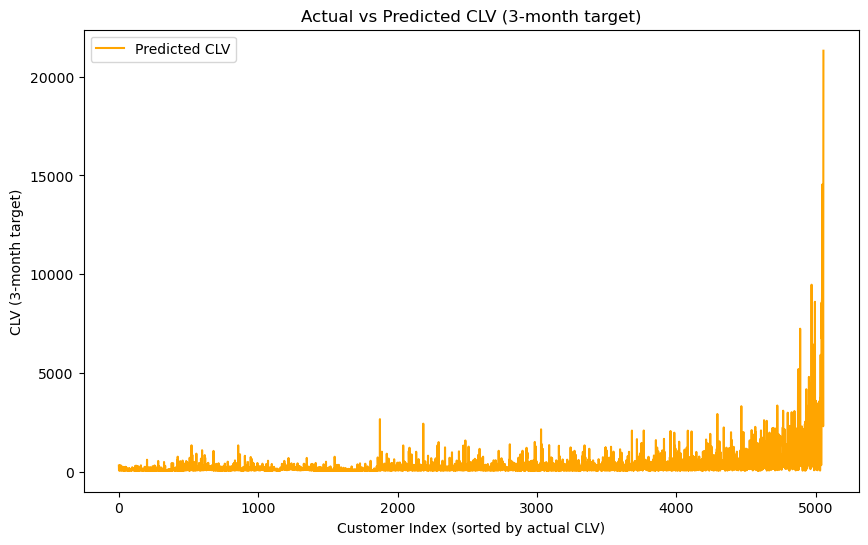

In [30]:
import matplotlib.pyplot as plt
plot_data = test_data.sort_values(by='clv_3_month_target').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 6))

import matplotlib.pyplot as plt
plt.plot(plot_data['y_hat'], label='Predicted CLV', color='orange', )
#plt.plot(plot_data['clv_3_month_target'], label='Actual CLV', color='blue',)

plt.xlabel('Customer Index (sorted by actual CLV)')
plt.ylabel('CLV (3-month target)')
plt.title('Actual vs Predicted CLV (3-month target)')
plt.legend()
#plt.ylim(0,20000)

plt.show()


In [137]:
CTGNN_monthly = test_data[['clv_3_month_target', 'y_hat']].copy()
CTGNN_monthly.to_csv('CTGNN_results_monthly.csv', index=False)
